# Objective

Implement a neural network.


### Function implementations


* sigmoid
* softmax
* cross entropy log loss (binary and categorical)

### Layer implementations


* Standardization
* Matmul
* Activation (sigmoid, softmax)
* Log loss output
* Batch normalization (TBD)

Mathjax formulas get corrupted in github.

### Classifier Implementations

* Binary classifiation with (matmul-loss) layers.
* Categorical classifiation with (matmul-ReLu-matmul-Relu-loss) layers.

# References

* [CS231n: Convolutional Neural Networks for Visual Recognition 2017](http://cs231n.stanford.edu/2017/syllabus)
    - [cs231n 2017 assignment #1 kNN, SVM, SoftMax, two-layer network](https://cs231n.github.io/assignments2017/assignment1/)
    - [Training a Softmax Linear Classifier](https://cs231n.github.io/neural-networks-case-study)
* [ゼロから作る Deep Learning](https://github.com/oreilly-japan/deep-learning-from-scratch)
* [Mathematics for Machine Learning](https://mml-book.github.io/)

---

# Neural network overview

Structure of the network and how forward and backward propagations work.

<img src="image/nn_diagram.png" align="left">

# Concepts 

## Objective function

The network trains the layers so as to minimize the objective function ```L``` which calculates the loss. Each layer at ```i``` is a function $f_i$ which takes an input $X_i$ from a previous layer and outputs $Y_i = f(X_i)$. The post layers of the form an objective function $L_i$ for the layer: $L = L_i(Y_i)$. 


<img src="image/nn_functions.png" align="left">

## Forward path

The process where each layer ```i``` calculate its output $Y_i = f(X_i)$ and forward it to the next layer(s) as their input $X_{i+1}$.

## Backward path

The process of automatic differentication, or *back-propagation* where each layer calculates its gradient $\frac {\partial L_i(Y_i)}{\partial Y_i}$ , that is, the impact $Y_i$ will make on the objective ```L``` when it changes. With the gradient, we can apply the gradient descent $X_i = X_i - \lambda  \frac {\partial L_i(Y_i)}{\partial Y_i} \frac {\partial Y_i }{\partial X_i}$ to update $X_i$ that would reduce the objective ```L```.

## Cycle

A round-trip of a forward path and a backward path with a batch data set $(X, T)$. How many cycles to happen with each batch is an implementation decision. 

## Epoch

Total cycles to consume the entire training data.

---

# Terminologies

## X
A batch input to a layer. Matrix shape is ```(N, D)```.

* ```N``` : Number of rows in a batch X, or batch size
* ```D``` : Number of features in a data in X.


## T
Labels for X. There are two formats available for the label.

#### One Hot Encoding (OHE) labels

When a neural network predicts a class out of ```3``` classes for an input ```x``` and the correct class is ```2```, then the label ```t``` is specified as ```t = [0, 1, 0]```.

$
\begin{align*}
\overset{ (N,M) }{ T_{_{OHE}} } &= ( 
    \overset{ (M,) }{ T_{(n=0)} }, \dots , \overset{ (M,) }{ T_{(n=N-1)} } 
) 
\\
\overset{ (M,) }{ T_{ _{OHE} (n)} } &= ( \overset{ () }{ t_{(n)(m=0)} }, \; \dots \;, \overset{ () }{ t_{(n)(m=M-1)} })
\end{align*}
$

#### Index labels

The label ```t``` is specified as ```t = 2```. 

$
\begin{align*}
\overset{ (N,) }{ T_{_{IDX}} } &= (\overset{ () }{ t_{(n=0)} }, \; \dots \;, \overset{ () }{ t_{(n=N-1)} }) \end{align*}
$

## W
A set of weight parameters of a node in a Matmul layer. Shape is ```(M, D)```.

* ```M``` : Number of nodes in a layer



# Matrix order

Use the row-order matrix. For instance, the weight matrix ```W``` of a Matmul layer has a shape ```(M, D)``` where each row in ```W``` represents a node in the layer. It will be efficient to use the column order matrix of shape ```(D, M)``` for ```W``` so that the matrix multiplication at a Matmul layer can be executed as ```X@W```  which is a ```shape:(N,D) @ shape:(D,M)``` operation without transpose. 

However, for the purpose of consistency and clarity, use the shape ```W:(M, D)``` although it will cause transposes ```W.T``` at the Matmul operations, and revese transposing ```dL/dW.T``` to ```dL/dW``` when updating ```W``` at the gradient descents.


---

# Python & Jupyter setups

In [1]:
from typing import (
    Optional,
    Union,
    List,
    Dict,
    Tuple,
    Callable
)

### Python path
Python path setup to avoid the relative imports.

In [2]:
import sys
import os 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Package dependencies

In [3]:
import inspect
from functools import partial
import logging
import numpy as np
import matplotlib.pyplot as plt

### Jupyter notebook

In [48]:
#!conda install line_profile memory_profiler
%load_ext memory_profiler
%load_ext line_profiler

# Logging is enabled by calling logging.basicConfig
# logging.basicConfig(stream=sys.stdout, level=logging.ERROR)
# Logger = logging.getLogger("neural_network")

%load_ext autoreload
%autoreload 2

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Matplotlib

In [5]:
import matplotlib.style as mplstyle
mplstyle.use('fast')
plt.ion()

# Note: with notebook backend from the top, updating the plot line does not work...
%matplotlib notebook
# %matplotlib inline

### numpy

In [6]:
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=80) 

---

---

# Normalization Layer
Apply normalization or use batch normaliation.

---

# Matmul layer

In [7]:
from common import (
    xavier,
    he,
    uniform
)
from layer.matmul import Matmul

## Forward path
$
\begin{align*}
\overset{ (N,M) }{ Y } 
&= 
\begin{bmatrix}
{ Y_{(n=0)} } \\
\vdots \\
{ Y_{(n)} } \\
\vdots \\
{ Y_{(n=N-1)} }
\end{bmatrix}
=
\overset{ (N,D) }{ X } \; @ \; \overset{ (D,M) }{ W^T }
\\
\\
\overset{ (M,) }{ Y_{(n)} } &= (y_{(n)(m=0)}, \; \dots, \; y_{(n)(m)},  \; \dots, \; y_{(n)(m=M-1)})
\\
\overset{ () }{ y_{(n)(m)} }
&= \overset{ (D,) }{ X_{(n)} } \cdot \overset{ (D,) }{ W_{(m)}^T }
= \sum\limits ^{D}_{d=0}  \overset{ () }{ x_{(n)(d)} } * \overset{ () }{ w_{(m)(d)} }
\\
_{(0 \le d \le D, \; 0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Backward path
### Gradient dL/dX

Impact on L by $dX$.

$
\begin{align*}
\overset { (N,D) }{ \frac {\partial L }{ \partial X } }
= \overset { (N,M) }{ \frac {\partial L}{\partial Y} }
@ \overset { (M,D) }{ W } 
\end{align*}
$
<img src="image/nn_back_propagation_dL_dX.png" align="left" />

### Gradient dL/dW.T
Impact on L by $dW^T$.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial W^T } }
= \overset { (D,N) }{ X^T } 
@ 
\overset { (N,M) }{ \frac {\partial L}{\partial Y} }
\end{align*}
$

<img src="image/nn_back_propagation_dL_dWT.png" align="left" />

---

# Activation layer

## Forward path
$
\begin{align*}
\overset{ (N,M) }{ A } &= 
activation \left( 
    \overset{ (N,M) }{ Y }  = 
    \begin{bmatrix}
    { Y_{(n=0)} } \\
    \vdots \\
    { Y_{(n)} } \\
    \vdots \\
    { Y_{(n=N-1)} }
    \end{bmatrix}
\right)
\\
\overset{ (M,) }{ A_{(n)} } 
&= activation \left( \overset{ (M,) }{ Y_{(n) }} \right)  \\
&= (a_{(n)(m=0)}, \; \dots, \; a_{(n)(m)},  \; \dots, \; a_{(n)(m=M-1)})
\\
\overset{ () }{ a_{(n)(m)} } &= activation \left( \overset{ () }{ y_{(n)(m)} } \right)
\quad _{(0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Backward path
### Gradient dL/dY

Impact on L by dY from the matmul layer.

$
\begin {align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial Y } }
= \overset { (N,M) }{ \frac {\partial L}{\partial A} } 
* 
\overset { (N,M) }{ \frac {\partial A}{\partial Y} }
\end {align*}
$

#### For sigmoid activation

$
\begin{align*}
\overset {(N,M)}{\frac { \partial L }{ \partial Y} }
&= \frac { \partial A }{ \partial Y} * A * (1 - A)
\\
\frac { \partial y_{(n)(m)} } { \partial a_{(n)(m)} }
&= a_{(n)(m)} * (1 - a_{(n)(m)} )  \\ 
y_{(n)(m)} = sigmoid(a_{(n)(m)} )&=  \frac {1}{ 1 + exp(y_{(n)(m)})}
\end{align*}
$

#### For ReLU activation

$
\begin{align*}
\frac { \partial a_{(n)(m)} }{ \partial y_{(n)(m)} }
&= 1 \quad y_{(n)(m)}  \gt 0 \\
&= 0 \quad y_{(n)(m)}  \le 0 \\
\end{align*}
$

---

# Softmax layer
$C_n$ is to prevent the overflow at $np.exp()$.

<img src="image/softmax.png" align="left" width=400/>

exp(x) can take all x values and produces a positive, which is required for log(y) that needs y > 0, hence fit-for-purpose to build a probability function.

<img src="image/exp.gif" align="left" width=250/>

Softmax and Cross Entropy Log Loss are combined as the gradient results in a simple form $P - T$.

In [8]:
from layer import CrossEntropyLogLoss
from common import softmax

lines = inspect.getsource(softmax)
print(lines)

def softmax(X: Union[np.ndarray, float]) -> Union[np.ndarray, float]:
    """Softmax P = exp(X) / sum(exp(X))
    Args:
        X: batch input data of shape (N,M).
            N: Batch size
            M: Number of nodes
    Returns:
        P: Probability of shape (N,M)
    """
    name = "softmax"
    assert isinstance(X, float) or (isinstance(X, np.ndarray) and X.dtype == TYPE_FLOAT), \
        "X must be float or ndarray(dtype=TYPE_FLOAT)"

    # --------------------------------------------------------------------------------
    # exp(x-c) to prevent the infinite exp(x) for a large value x, with c = max(x).
    # keepdims=True to be able to broadcast.
    # --------------------------------------------------------------------------------
    C = np.max(X, axis=-1, keepdims=True)
    # exp = np.exp(X - C)
    exp = ne.evaluate("exp(X - C)")
    P = exp / np.sum(exp, axis=-1, keepdims=True)
    Logger.debug("%s: X %s exp %s P %s", name, X, exp, P)

    return P



## Foward path
$
\begin{align*}
\overset{ (N,1) }{ C } &= np.max\left( 
    \overset{ (N,M) }{ A }, \; axis=-1,  \; keepdim=True 
\right) \\
&=  
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ c_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ (N,M) }{ EXP } &= np.exp \left( \overset{ (N,M) }{ A } - \overset{ (N,1) }{ C } \right)
= np.exp \left(
    \begin{bmatrix}
    { A_{(n=0)} } - { C_{(n=0)} }\\
    \vdots \\
    { A_{(n)} }   - { C_{(n)} }\\
    \vdots \\
    { A_{(n=N-1)} } - { C_{(n=N-1)} }\\
    \end{bmatrix}
\right) 
\\
&= 
\begin{bmatrix}
    e_{(n=0)(m=0)}   & \dots      & e_{(n=0)(m=M-1)}   \\  
    \vdots           & e_{(n)(m)} & \vdots             \\
    e_{(n=N-1)(m=0)} & \dots      & e_{(n=N-1)(m=M-1)} 
\end{bmatrix} 
\\
\\
\overset{ (N,1) }{ S } &= \overset{ (N,1) }{ sum(EXP) } = np.sum \left( 
    \overset{ (N,M) }{ EXP }, \; axis=-1,  \; keepdim=True 
\right)
\\
&= 
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ s_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ () }{ s_{(n)} } &= \sum\limits ^{M-1}_{m=0} np.exp(\; a_{(n)(m)} - c_{(n)} \; )
\\
\\
\overset{ (N,M) }{ P } &= \overset{ (N,M) }{ EXP }  \;\; / \;\; \overset{ (N,1) }{ sum(EXP) } 
\\
\overset{ (N,) }{ P_{(n)} } &= (p_{(n)(m=0)}, \; \dots, \; p_{(n)(m)} , \; \dots, \; p_{(n)(m=M-1)})
\\
{ p_{(n)(m)} } 
&= \frac {np.exp \left( 
    { a_{(n)(m) } } - { c_{(n)} }) \right) 
}
{  
np.sum \left( 
    np.exp \left( 
        a_{(n)(m) } - c_{(n)}
    \right)
\right) 
}
\end{align*}
$

## Backward path

### Gradient dL/dA

Impact on L by dA from the activation layer.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{\partial A} }
= \overset { (N,M) }{ \frac {\partial L}{\partial P} }
* 
\overset { (N,M) }{ \frac {\partial P }{\partial A} } 
= 
\frac {1}{N} (P - T)
\end{align*}
$

$
Jacobian \; : \; f \circ g \rightarrow Jf \circ Jg
\\
\begin{align*}
\\
L &= f(\; p_{(n)(m=0)} \;) = f( \; g(\;  a_{(n)(m=0)} \; ) \; ) \quad : p = g(a) = softmax(a)
\\
\frac {\partial L} { \partial a_{(n)(m=0)} }
&= Jf(p) \circ Jg(a) 
=  \frac {\partial L} { \partial p_{(n)(m=0)} } * \frac {\partial  p_{(n)(m=0)}} { \partial a_{(n)(m=0)} }
\\
&= \frac {1}{N} \left(
 p_{(n)(m=0)} -t_{(n)(m=0)}
\right)
\end{align*}
$

The formula is calculated by chaing the gradient from ***cross-entropy-log-loss***, and the gradients of the steps in ***softmax***.

#### Gradient from the cross entropy log loss

$
\begin{align*}
\frac { \partial L }{ \partial  p_{(n)(m=0)} }
&= \frac{-1}{N} t_{(n)(m=0)} * \frac {s_{(n)}}{e_{(n)(m=0)}}
\\
\frac { \partial L }{ \partial  p_{(n)(m=1)} } 
&= \frac{-1}{N} t_{(n)(m=1)} * \frac {s_{(n)}}{e_{(n)(m=1)}}
\end{align*}
$


####  Gradient $\frac { \partial  L } { \partial s^{-1}_{(n)} } $

$
\begin{align*}
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} } \\
p_{(n)(m=0)} &= f \circ g_{(m=0)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=0)} }
\rightarrow \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=0)}
\\
p_{(n)(m=1)} &= \frac {e_{(n)(m=1)} }{ s_{(n)} } \\
p_{(n)(m=1)} &= f \circ g_{(m=1)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=1)} }
\rightarrow \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=1)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    +
    \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\\
&= \sum\limits^{M-1}_{m=0} 
    e_{(n)(m)}  * \frac { \partial L }{ \partial  p_{(n)(m)} } 
\\
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
    \begin{bmatrix}
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } \\
    + \\
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
    \end{bmatrix}
\\
&= -s_{(n)}(\; t_{(n)(m=0)} + t_{(n)(m=1)} \;) \\
&= -s_{(n)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    + 
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\end{align*}
$

#### Gradient $\frac {\partial L }{ \partial { s_{(n)} } } $

$
\begin{align*}
\frac {1} { s_{(n)} } &= s^{-1}_{(n)} \rightarrow
\frac { \partial { s^{-1}_{(n)} } } {\partial s_{(n)}} = \frac {-1}{s^{2}_{(n)}}
\\
\frac {\partial L }{ \partial { s_{(n)} } } 
&=
\frac {-1}{s^{2}_{(n)}} * 
\frac {\partial L}{ \partial s^{-1}_{(n)} } \\
&= \frac {1}{s_n}
\end{align*} \\
$



#### Gradient $\frac {\partial L}{ \partial e_{(n)(m=0)} } $
$
\begin{align*}
s_{(n)} &= \sum\limits ^{M-1}_{m=0} e_{(n)(m)} \rightarrow 
\frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} = 1
\\
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} }\rightarrow 
\frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} = \frac {1}{s_{(n)}}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } 
&= \begin{bmatrix}  
    \frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} *  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
= \begin{bmatrix}  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\left[
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
    + 
    \frac {\partial L }{ \partial { s_{(n)} } } 
\right]
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\begin{bmatrix}  
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} }  \\
    +  \\
    \frac {\partial L }{ \partial s_{(n)} } 
\end{bmatrix} \\
&= \frac {-t_{(n)(m=0)}}{e_{(n)(m=0)} } + \frac {1}{s_{n}}
\end{align*}
$



#### Gardient $\frac {\partial L}{ \partial a_{(n)(m=0)} } $

$
\begin{align*}
e_{(n)(m)} &= exp(\; a_{(n)(m)} \; ) \rightarrow \frac { \partial e_{(n)(m)} }{ \partial a_{(n)(m)} } = e_{(n)(m)} 
\\
e_{(n)(m=0)} &= exp(a_{(n)(m=0)}) \rightarrow \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } = e_{(n)(m=0)} 
\\
e_{(n)(m=1)} &= exp(a_{(n)(m=1)}) \\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&=   \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } * 
    \frac { \partial L }{ \partial e_{(n)(m=0)} } 
= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } 
\\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } \\
&= -t_{(n)(m=0)} + \frac { e_{(n)(m=0)} }{ s_{n} } \\
&= p_{(n)(m=0)} -t_{(n)(m=0)} 
\end{align*}
$

---

# Cross Entropy Log Loss

A probability distribution $P(x)$ can be represented with its entropy $E(x) = \sum\limits_{x}  \frac {p(x)}{log(p(x)} = - \sum\limits_{x} p(x) log(p(x))$. In the diagram, x: (0:dog, 1:cat, 2:fish, 3:bird) are labels and p(dog) is 0.5. When  a NN predicts an input x as a probability distribution $P(x)$, then the $E(x) = 1.75$. 

0. $p(dog)=\frac {1}{2}$
1. $p(cat)=\frac {1}{4}$
2. $p(fish)=\frac {1}{8}$
3. $p(bird)=\frac {1}{8}$

When the truth is that x is a dog, then the probability distribution of the truth $P(t)$ has the entropy $E(t) = 0$.

0. $p(dog)=1$
1. $p(cat)=0$
2. $p(fish)=0$
3. $p(bird)=0$

The difference E(x) - E(t) = E(x) = 1.75 can be used as the distance or the error of the prediction from the truth. Need to understand further but  the actuall loss function is $E(x) = -tlog(p(x)) = -log(p(x))$ where p(x) is the probability from the softmax for the correct label.


<img src="image/entropy.png" align="left" width=600/><br>

np.log() is ln based on the mathematical constant $e$ and its derivative $\frac {\partial log(x)}{\partial x} = \frac {1}{x}$.

* [Logarithm](https://en.wikipedia.org/wiki/Logarithm)


<img src="image/logarithm_plots.png" align="left" width=300/>

* [ML Grossary - Loss Functions](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)

<img src="image/cross_entropy_log_loss.png" align="left" width=500/>

[cross_entropy_log_loss_input_combinations.xlsx](./common/cross_entropy_log_loss_input_combinations.xlsx)

In [9]:
from common import (
    cross_entropy_log_loss,
    OFFSET_LOG
)
lines = inspect.getsource(cross_entropy_log_loss)
print(lines)

def cross_entropy_log_loss(
        P: Union[np.ndarray, float],
        T: Union[np.ndarray, int],
        f: Callable = categorical_log_loss,
        offset: float = OFFSET_LOG
) -> np.ndarray:
    """Cross entropy log loss [ -t(n)(m) * log(p(n)(m)) ] for multi labels.
    Args:
        P: activation or probabilities from an activation function.
        T: labels
        f: Cross entropy log loss function f(P, T) where P is activation, T is label
        offset: small number to avoid np.inf by log(0) by log(0+offset)

    Returns:
        J: Loss value of shape (N,), a loss value per batch.

    NOTE:
        Handle only the label whose value is True. The reason not to use non-labels to
        calculate the loss is TBD.

        See transform_X_T for the format and shape of P and T.
    """
    name = "cross_entropy_log_loss"
    P, T = transform_X_T(P, T)
    if P.ndim == 0:
        assert False, "P.ndim needs (N,M) after transform_X_T(P, T)"
        # -----------------------------

## For label using One Hot Encoding (OHE)
For instance, if multi labels are (0,1,2,3,4) and each label is OHE, then the label for 2 is (0,0,1,0,0).   


### Product of matrix rows

There is no formal operation to calculate the dot products of the rows from two matrices, but to calculate the diagonal of the matlix multiplication that also calculate non-diagonals. To avoid calculating non-diagonals, use [einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html).

* [Name of matrix operation of ```[A[0] dot B[0], A[1] dot B[1] ]``` from 2x2 matrices A, B](https://math.stackexchange.com/questions/4010721/name-of-matrix-operation-of-a0-dot-b0-a1-dot-b1-from-2x2-matrices-a)

<img src="image/dot_products_of_matrix_rows.png" align="left"/>


In [10]:
import numpy as np

a = np.arange(6).reshape(2,3)
b = np.arange(0,-6,-1).reshape(2,3)
c = [
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
]
print(f"a is \n{a}")
print(f"b.T is \n{b.T}\n")
fmt=f"""c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is {c}\n
"""
print(fmt)

# Use einsum
e = np.einsum('ij,ji->i', a, b.T)
fmt="np.einsum('ij,ji->i', a, b.T)"
print(f"{fmt} is {e}")

a is 
[[0 1 2]
 [3 4 5]]
b.T is 
[[ 0 -3]
 [-1 -4]
 [-2 -5]]

c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is [-5, -50]


np.einsum('ij,ji->i', a, b.T) is [ -5 -50]


### Foward path (OHE)
$
\text{ for one hot encoding labels }
\\
\begin{align*}
\overset{ (N,) }{ J } &= - \sum\limits^{M-1}_{m=0} 
    \left[ \; \;  
        t_{(n)(m)} \;  * \;  np.log(p_{(n)(m)}) \;\;  
    \right]
\\
\overset{ () }{ j_{(n)} } &= \overset{ (M,) }{ T_{(n)} } \cdot \overset{ (M,) }{ P_{(n)} } 
\end{align*}
$

### Gradient dL/dP

Impact on L by the $dP$ from the softmax layer for one hot encoding labels.

$
\begin{align*}
\overset { (N,M) }{ \frac { \partial L }{ \partial P} }
&= \overset { (N,) }{ \frac { \partial L }{ \partial J} } * 
\overset { (N,M) }{ 
\left(
 - \frac { \partial T } { \partial P }
 \right) 
} 
= - \frac {1}{N }  \frac { \partial T } { \partial P }
\\
\frac {\partial L }{\partial p_{(n)(m=0)}} 
&= \frac {\partial L}{\partial j_{(n)}} * \frac {\partial j_{(n)}} {\partial p_{(n)(m=0)}} 
= \frac {1}{N} \frac { -t_{(n)(m=0)}}{ p_{(n)(m=0)} } 
=  \frac {1}{N} \left(
 -t_{(n)(m=0)} * \frac { s_{(n)} }{ e_{(n)(m=0)} }
\right)
\end{align*}
$

## For label using indexing 
For instance, if the multi labels are (0,1,2,3,4) then the index is 2 for the label 2. If the labels are (2,4,6,8,9), then the index is 3 for the label 8.  

Use LP to select the probabilities from P for the corresponding labels. For instance, if the label is 2 (hence the index is 2) for X(n=0), and 4 for X(n=3), then the numpy tuple indexing selects ```P[n=0][m=2]``` and ```P[n=3][m=4] ```.

```
P[
   (0, 3),
   (2, 4)
]
```

$
\text{ for index labels e.g. (5, 2, 0, 9, ...)}
\\
\\
\overset{ (N,) }{ J } = - np.sum(\; np.log(LP), \; axis = -1 \;) \\
LP = label\_probability = P \left[ \\
\quad ( \; 0, \; \dots, \;  {N-1}) , \\
\quad ( \; t_{(n=0)} \; , \dots , \; t_{(n=N-1)}) \\
\right]
\\
\\
$

---

# Total loss

## Forward path
$
\begin{align*}
\overset{ () }{ L } = \frac {1}{N} \sum\limits^{N-1}_{n=0} \overset{ () }{ j_{{(n)}} }
\end{align*}
$

## Gardient dL/dJ

Impact on L by $dJ$ from the cross entropy log loss layer.

$
\begin{align*}
\overset { (N,) }{ \frac {\partial L}{\partial J} }  &= \frac {1}{N} \overset{(N,)}{ones}
\\
\frac {\partial L}{\partial j_{(n)} } &= \frac {1}{N} 
\end{align*}
$

In [12]:
N = 3
dJ = np.ones(N) / N
dJ

array([0.33333333, 0.33333333, 0.33333333])

---


# Gradient check

## Numerical gradient

The objective of back-propagation is to analytically calculate the gradient of the objective function $g(X_i) = \frac {\partial L_i(Y_i)}{\partial Y_i} \frac {\partial Y_i}{\partial X_i}$ at each layer. Suppose the shape of $X_i$ is ```(N, M)```. We can take an element of X at an index ```(n,m)``` and add a small change ```h```, then see what impact ```h``` makes by calculating the numerical gradient ```gn``` as: $
\begin {align*}
gn(X_i) = \frac {L_i(f_i(X_i+h)) - L_i(f_i(X_i-h))} {2h }
\end {align*}
$. Then $gn(X_i) \approx \; $gn(X_i)$ would assure the gradient calculation should be correct.

In [13]:
from common import (
    numerical_jacobian,
    OFFSET_DELTA
)
lines = inspect.getsource(numerical_jacobian)
print(lines)

def numerical_jacobian(
        f: Callable[[np.ndarray], np.ndarray],
        X: Union[np.ndarray, float],
        delta: Optional[TYPE_FLOAT] = OFFSET_DELTA
) -> np.ndarray:
    """Calculate Jacobian matrix J numerically with (f(X+h) - f(X-h)) / 2h
    Jacobian matrix element Jpq = df/dXpq, the impact on J by the
    small difference to Xpq where p is row index and q is col index of J.

    Note:
        Beware limitations by the float storage size, e.g. loss of significance.
        https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/Contents/
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/02Numerics/Weaknesses/
        https://www.cise.ufl.edu/~mssz/CompOrg/CDA-arith.html

    Args:
        f: Y=f(X) where Y is a scalar or shape() array.
        X: input of shame (N, M), or (N,) or ()
        delta: small delta value to calculate the f value for X+/-h
    Returns:
        J: Jacobian matrix that 


### Consideration

#### Instability of numerical calculations

A float number can have infinite length e.g. ```1/3``` in the real world, but a computer needs to approximate it by rounding it to fit into a limited storage. Need to assure numerical errors are prevented or detected while calculating gradient numerically. See [Numerical errors](numerical_errors.ipynb). 

### Example 

Comparing the analytical gradient and the numerical gradient of a logistic log loss ```L = -(1-T) * log(Z)``` where ```T = 0``` and ```Z=sigmoid(X)```.

In [14]:
def t_0_logistic_log_loss(X):
    """Logistic log loss function"""
    # --------------------------------------------------------------------------------
    # For numerical stability, re-forumulate the logistic log loss -(1-T)log(1-Z) as
    # X + log(1+exp(-X)).
    
    # By Reza.B
    # Let z=1/(1+p), p= e^(-x), then log(1-z)=log(p)-log(1+p), which is more stable
    # in terms of rounding errors (we got rid of division, which is the main issue 
    # in numerical instabilities). 
    # --------------------------------------------------------------------------------
    L = np.sum(X + np.log(1 + np.exp(-X)))
    return L.tolist()

def gradient_t_0_loss(X):
    return 1 / (1 + np.exp(-X))

X = np.random.uniform(-5, 5, (2,2))
print(f"The analytical and numerical gradients of the logistic log loss for X:\n{X}\n")

analytical_gradient = gradient_t_0_loss(X)
numerical_gradient = numerical_jacobian(t_0_logistic_log_loss, X)

print(f"Analytical gradient:\n{analytical_gradient}\n")
print(f"Numerical gradient:\n{numerical_gradient}")

The analytical and numerical gradients of the logistic log loss for X:
[[ 4.40427028 -3.10903073]
 [ 4.74842311  4.27943134]]

Analytical gradient:
[[0.98792262 0.04273628]
 [0.99140909 0.98633868]]

Numerical gradient:
[[0.98792086 0.04273026]
 [0.9914114  0.98633102]]


---

# Binary classification

Use Matmul and CrossEntropyLogLoss layers to build a binary classifer.

In [53]:
%reload_ext autoreload
%autoreload 2
from common import (
    weights,
    transform_X_T,
    sigmoid_cross_entropy_log_loss,
    softmax_cross_entropy_log_loss
)
from data import (
    linear_separable
)
from optimizer import (
    Optimizer,
    SGD
)
from network import (
    train_binary_classifier
)
from drawing import (
    COLOR_LABELS,   # labels to classify outside/0/red or inside/1/green.
    plot_categorical_predictions
)

## X

Training data is two dimensional plots that can be linearly separable with a line whose normal is $(w1, w2)$ and point is $b=-w0/w2$. The line is written as $X \cdot W = 0$ where $W = (w0,w1,w2)$ and $X = (x0, x1, x2)$. $T$ are binary labels that tells if each plot is classfied as 0 or 1.

In [22]:
N = 500    # Number of plots
D = 2      # Number of features
from data import (
    linear_separable
)
X, T, V = linear_separable(d=D, n=N)
_X = np.c_[
    np.ones(n),     # Bias
    X
]
#print(f"X.shape {X.shape} T.shape {T.shape} W {V}")

### Classification goal

<IPython.core.display.Javascript object>


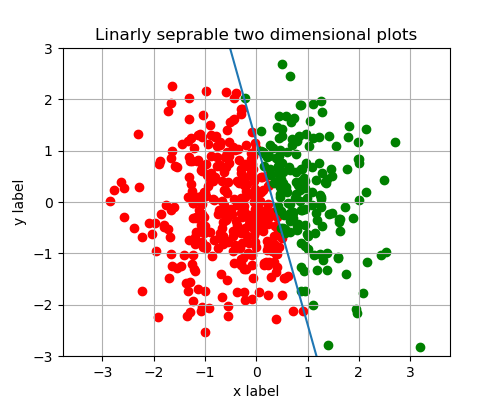

In [24]:
fig, ax = plt.subplots(figsize=(5,4))
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.set_title('Linarly seprable two dimensional plots')

ax.scatter(X[T==0, 0], X[T==0, 1], c='red')
ax.scatter(X[T==1, 0], X[T==1, 1], c='green')

# Hyperplace (X-b)V = 0 -> x1V1 + x2V2 - bV2 = 0
x = np.linspace(-3,3,100)
y = -(V[1] / V[2]) * x - (V[0] / V[2])
ax.plot(x, y)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.grid()

## Train binary classifiers
1. Sigmoid binary classifier
2. Softmax binary classifier

In [26]:
%matplotlib notebook

def draw_training(X, W, _ax=None, _fig=None, colors=['b']):
    w0 = W[0]
    w1 = W[1]
    w2 = W[2]
    
    #_ax.set_xlim(-3, 3)
    #_ax.set_ylim(-3, 3)
    #_ax.set_title(label=f"W: {W}")

    #_ax.scatter(X[T==0, 1], X[T==0, 2], c='red')
    #_ax.scatter(X[T==1, 1], X[T==1, 2], c='green')
    x = np.linspace(-3,3,100)
    if _ax.lines:
        for line in _ax.lines:
            line.set_xdata(x)
            y = -w1/w2 * x - w0 / w2
            line.set_ydata(y)
    else:
        for color in colors:
            y = -w1/w2 * x - w0 / w2
            _ax.plot(x, y, color)

    fig.canvas.draw()

    _x = np.linspace(-3,3,100)
    _y = -w1/w2 * x - w0 / w2
    _ax.plot(_x, _y, label='linear')  # Plot some data on the _axes.


<IPython.core.display.Javascript object>


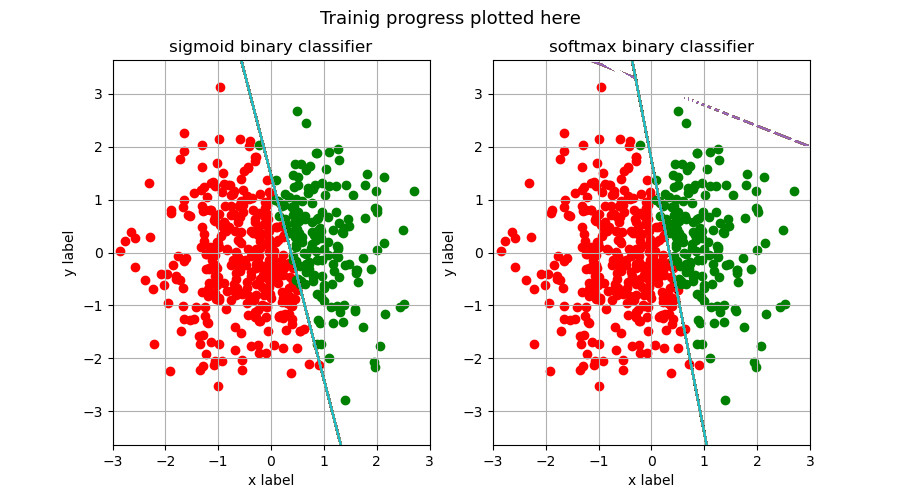

Text(0.5, 1.0, 'softmax binary classifier')

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(9,5))
for i in range(2):
    ax[i].scatter(X[T==0, 0], X[T==0, 1], c='red')
    ax[i].scatter(X[T==1, 0], X[T==1, 1], c='green')
    ax[i].set_xlabel('x label')
    ax[i].set_ylabel('y label')
    ax[i].axis('equal')
    ax[i].set_xlim(-3, 3)
    ax[i].set_ylim(-3, 3)
    ax[i].grid()

fig.suptitle('Trainig progress plotted here', fontsize=13)
ax[0].set_title("sigmoid binary classifier")
ax[1].set_title("softmax binary classifier")

## Sigmoid classifier training

Plots in the previous cell.

In [30]:
print(f"Train a sigmoid classifier to find optimal W {tuple(V)} for the boundary.")
MAX_TEST_TIMES = 100

M = 1
W = weights.xavier(M, D+1)    # Xavier initialization for Sigmoid
optimizer = SGD(lr=0.3)
draw = partial(draw_training, X=X, _fig=fig, _ax=ax[0])
ax[0].set_xlim(-3, 3)
ax[0].set_ylim(-3, 3)

train_binary_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=sigmoid_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False,
    callback=draw
)

Train a sigmoid classifier to find optimal W (-0.303579198588961, 0.9173410897051096, 0.25753639611271684) for the boundary.
iteration 0 Loss 0.8633768438330537
iteration 50 Loss 0.23076745096301737


array([[-1.10442796,  2.91554347,  0.75485323]])

In [31]:
%lprun \
    -T train_sigmoid_binary_classifier.log \
    -f train_binary_classifier \
    train_binary_classifier(\
        N=N,D=D,M=M,X=X,T=T,W=W,\
        log_loss_function=sigmoid_cross_entropy_log_loss, \
        optimizer=optimizer, \
        num_epochs=MAX_TEST_TIMES, \
        test_numerical_gradient=False \
    )

print(open('train_sigmoid_classifier.log', 'r').read())

iteration 0 Loss 0.17454920531470605
iteration 50 Loss 0.14902257808886893

*** Profile printout saved to text file 'train_sigmoid_binary_classifier.log'. 
Timer unit: 1e-06 s

Total time: 1.12744 s
File: /home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/network/test_020_one_layer_classifier.py
Function: train_classifier at line 48

Line #      Hits         Time  Per Hit   % Time  Line Contents
    48                                           def train_classifier(
    49                                                   N: int,
    50                                                   D: int,
    51                                                   M: int,
    52                                                   X: np.ndarray,
    53                                                   T: np.ndarray,
    54                                                   W: np.ndarray,
    55                                                   log_loss_function: Callable,
    56            

## softmax classifier training
Two class classification with softmax activation. 
Plots in the previous cell.

In [33]:
print(f"Train a softmax classifier to find optimal W {tuple(V)} for the boundary.")
MAX_TEST_TIMES = 200

M = 2                      
W = weights.he(M, D+1)
optimizer = SGD(lr=0.3)
draw = partial(draw_training, X=X, _fig=fig, _ax=ax[1])
ax[1].set_xlim(-3, 3)
ax[1].set_ylim(-3, 3)

train_binary_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False, 
    callback=draw
)

Train a softmax classifier to find optimal W (-0.303579198588961, 0.9173410897051096, 0.25753639611271684) for the boundary.
iteration 0 Loss 1.076360977905345
iteration 50 Loss 0.17235711097862794
iteration 100 Loss 0.13259079009708746
iteration 150 Loss 0.11404012291404941


array([[ 0.97874009, -2.88973844, -0.55980926],
       [-0.89795223,  2.27227327,  0.84402506]])

In [35]:
%lprun \
    -T train_softmax_binary_classifier.log \
    -f train_binary_classifier \
    train_binary_classifier(\
        N=N,D=D,M=M,X=X,T=T,W=W,\
        log_loss_function=softmax_cross_entropy_log_loss, \
        optimizer=optimizer, \
        num_epochs=MAX_TEST_TIMES, \
        test_numerical_gradient=False \
    )

print(open('train_softmax_classifier.log', 'r').read())

iteration 0 Loss 0.102579006742515
iteration 50 Loss 0.09453785591167778
iteration 100 Loss 0.08846628373556675
iteration 150 Loss 0.08365652321024636

*** Profile printout saved to text file 'train_softmax_binary_classifier.log'. 
Timer unit: 1e-06 s

Total time: 2.33835 s
File: /home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/network/test_020_one_layer_classifier.py
Function: train_classifier at line 48

Line #      Hits         Time  Per Hit   % Time  Line Contents
    48                                           def train_classifier(
    49                                                   N: int,
    50                                                   D: int,
    51                                                   M: int,
    52                                                   X: np.ndarray,
    53                                                   T: np.ndarray,
    54                                                   W: np.ndarray,
    55                      

---

# Categorical Classification

Use Matmul and CrossEntropyLogLoss layers to classify M categorical data.

In [50]:
%reload_ext autoreload
%autoreload 2
from common import (
    prediction_grid,
)
from data import (
    linear_separable_sectors,
)
from network import (
    train_matmul_relu_classifier
)

## Linearly separable multiple categories

### Data X and Label T
Training data to linearly classify into M categories and labels T.

In [46]:
print(f"Train a categorical classifier")
N = 300
D = 2      # Dimension
M = 3

rotation = np.radians(35)
# x0 = X[::,0] is the bias 1
X, T, B = linear_separable_sectors(n=N, d=D, m=M, r=2, rotation=rotation)

Train a categorical classifier


#### Plot X, T

<IPython.core.display.Javascript object>


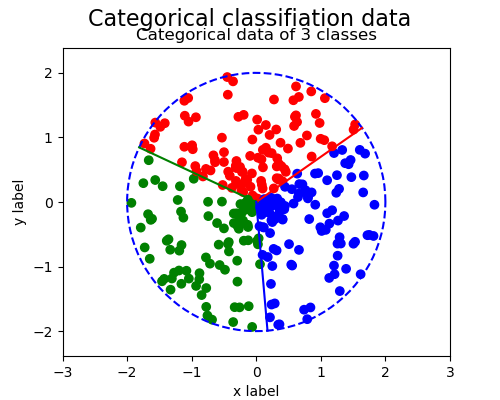

In [38]:
# Radius of a circle within which to place plots.
radius = 2   

# --------------------------------------------------------------------------------
# Plot area
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5,4))
for i in range(2):
    ax.set_xlabel('x label')
    ax.set_ylabel('y label')
    ax.axis('equal')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.grid()

ax.set_title(f"Categorical data of {M} classes")

# --------------------------------------------------------------------------------
# Cirle within which to place random plots.
# --------------------------------------------------------------------------------
r = np.linspace(0, 2 * np.pi, 100)
ax.plot(radius * np.cos(r), radius * np.sin(r), "b--")

# --------------------------------------------------------------------------------
# Classify plots (x, y) if inside the coverage sector
# labels to classify outside/0/red or inside/1/green.
# --------------------------------------------------------------------------------
Y = COLOR_LABELS[
    T
]

# --------------------------------------------------------------------------------
# Plot color-classified points.
# --------------------------------------------------------------------------------
ax.scatter(X[::,0], X[::,1], marker='o', color=Y)

# --------------------------------------------------------------------------------
# Plot sector bases
# --------------------------------------------------------------------------------
for i in range(B.shape[0]):
    ax.plot((0, radius * B[i, 0]), (0, radius * B[i, 1]), COLOR_LABELS[i])

# ax.legend()
fig.suptitle('Categorical classifiation data', fontsize=16)

plt.draw()
plt.show()


### Train on linearly separable multiple categories

In [39]:
MAX_TEST_TIMES = 1000
W = weights.he(M, D+1)
optimizer = SGD(lr=0.3)

train_matmul_relu_classifier
# W = train_classifier(
W = train_matmul_relu_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False
)

Expected dL/dW 
[[-0.07477798  0.01994175 -0.08547085]
 [-0.00139698  0.22747891  0.07377173]
 [ 0.00697645 -0.15234675  0.01516596]]
Diff
[[ 0.00646183  0.00011423  0.0042427 ]
 [-0.00034917 -0.01069353 -0.00371398]
 [-0.00535749  0.00785502  0.00191211]]


iteration 0 Loss 1.1489692984342963
iteration 50 Loss 0.42891965074057414
iteration 100 Loss 0.327231894802883
iteration 150 Loss 0.28042593007358313
iteration 200 Loss 0.2517206066119172
iteration 250 Loss 0.23169137453765037
iteration 300 Loss 0.21659866692610477
iteration 350 Loss 0.20464004685139373
iteration 400 Loss 0.19483629126874769
iteration 450 Loss 0.1865955538130802
iteration 500 Loss 0.17952966611639493
iteration 550 Loss 0.17337805610584756
iteration 600 Loss 0.16795458293936064
iteration 650 Loss 0.16312161194208977
iteration 700 Loss 0.15877767660744369
iteration 750 Loss 0.15484425563138837
iteration 800 Loss 0.15125967852792965
iteration 850 Loss 0.1479788270722742
iteration 900 Loss 0.14495549702503813
iteration 950 Loss 0.1421554148130185


### Run predictions

Run preditions against the grid coordinates (x1, x2).
```
x1: X[:, 1].min() - 1 <= x1 <=  X[:, 1].max() + 1
x2: X[:, 2].min() - 1 <= x2 <=  X[:, 2].max() + 1
grid = np.meshgrid(x1, x2)

# np.argmax(scores) selets the highest score for each data point in X.
# e.g score[i] = [0.2, 8.2, 0.3], then np.argmax(scores[i]) selects index 1 as the prediction. 
# Then cluster of predition/label == 1 will form a contour.
sores = grid @ W.T
predictions = p.argmax(score, axis=1)
```

### Plot predictions

<IPython.core.display.Javascript object>


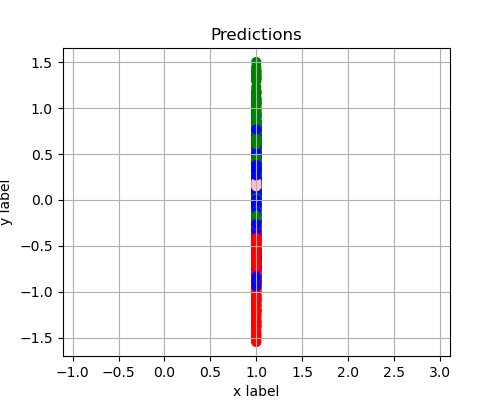

In [67]:
fig, ax = plt.subplots(figsize=(5,4)) 
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()
ax.set_title("Predictions")
#ax.set_xlim(-3, 3)
#ax.set_ylim(-3, 3)

x_grid, y_grid, predictions = prediction_grid(X, W)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

plt.show()

## Non-linearly separable data

In [82]:
%reload_ext autoreload
%autoreload 2

from data import (
    set_in_a_radius,
    sets_of_circle_A_not_B
)
from common import (
    prediction_grid_2d
)
from network import (
    train_two_layer_classifier
)

### Data X and Label T
Training data set that cannot be linearly classified. ```X = ((A not B), (B not C), (C not A), (A and B and C and D))``` for circles A, B, C.

<IPython.core.display.Javascript object>


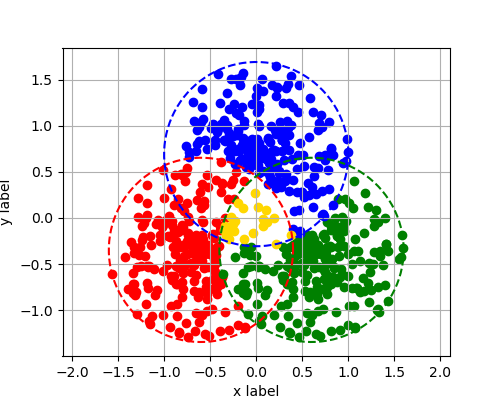

In [71]:
__M = 3        # Number of circles
__N = 300
radius = 1
circles, centres, intersection = sets_of_circle_A_not_B(radius=radius, ratio=1.2, m=__M, n=__N)

fig, ax = plt.subplots(figsize=(5,4)) 
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()
r = np.linspace(0, 2*np.pi, 100)

# (A not B), (B not C), (C not A)
for i in range(__M):
    circle = circles[i]
    if circle.size > 0:
        x = centres[i][0]
        y = centres[i][1]
        ax.scatter(circle[::, 0], circle[::, 1], color=COLOR_LABELS[i])
        ax.plot(
            x + radius * np.cos(r), 
            y + radius * np.sin(r), 
            linestyle='dashed', 
            color=COLOR_LABELS[i]
        )

# (A and B and C and D)
M = __M + 1
ax.scatter(intersection[::, 0], intersection[::, 1], color='gold')

In [75]:
# Stack all circles and intersect
X = np.vstack(
    [circles[i] for i in range(M-1)] + 
    [intersection]
)

T = np.hstack(
    [np.full(circles[i].shape[0], i) for i in range(M-1)] + 
    [np.full(intersection.shape[0], M-1)]
)
N = T.shape[0]
assert T.shape[0] == X.shape[0]

# Shuffle the data
indices = np.random.permutation(range(T.shape[0]))
X = X[indices]
T = T[indices]
Y = COLOR_LABELS[T]


print(f"X:{X.shape} T:{T.shape} ")

X:(710, 2) T:(710,) 


### Train on non-linear separable data

In [ ]:
MAX_TEST_TIMES = 50000
D = 2
M1 = 8
W1 = weights.he(M1, D+1)
M2: int = M                 # Number of categories to classify
W2 = weights.he(M2, M1+1)
optimizer = SGD(lr=0.3)

X, T = transform_X_T(X, T)
W1, W2, objective, prediction = train_two_layer_classifier(
    N=N,
    D=D,
    X=X,
    T=T,
    M1=M1,
    W1=W1,
    M2=M2,
    W2=W2,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False
)

iteration 0 Loss 1.454801504077128
iteration 100 Loss 0.6470005679572944
iteration 200 Loss 0.611234167929042
iteration 300 Loss 0.6016994584435119
iteration 400 Loss 0.5968658214578516
iteration 500 Loss 0.5937018199111886
iteration 600 Loss 0.5911075029896531
iteration 700 Loss 0.588923661751035
iteration 800 Loss 0.5870148510340498
iteration 900 Loss 0.585253589257175
iteration 1000 Loss 0.5837205610371312
iteration 1100 Loss 0.5823113265585108
iteration 1200 Loss 0.5809986981640078
iteration 1300 Loss 0.5797299569762275
iteration 1400 Loss 0.5785078396258879
iteration 1500 Loss 0.5773270299472391
iteration 1600 Loss 0.576148671885662
iteration 1700 Loss 0.574955488965981
iteration 1800 Loss 0.57374071345405
iteration 1900 Loss 0.5725069945134733
iteration 2000 Loss 0.5712623445039976
iteration 2100 Loss 0.5699960388507749
iteration 2200 Loss 0.5687141615931256
iteration 2300 Loss 0.5674266525017063
iteration 2400 Loss 0.5661318607470501
iteration 2500 Loss 0.564827598041722
iterati

Iteration [8221]: Loss[0.5295510949516281] has not improved from the previous [0.5295488270402048] for 1 times.


iteration 8200 Loss 0.5295797384167018


Iteration [8241]: Loss[0.5295219338984952] has not improved from the previous [0.5295201737530533] for 1 times.
Iteration [8281]: Loss[0.5294633829373351] has not improved from the previous [0.5294633510305927] for 1 times.
Iteration [8301]: Loss[0.5294354176198562] has not improved from the previous [0.5294351678464073] for 1 times.


iteration 8300 Loss 0.5294351678464073
iteration 8400 Loss 0.5292955254104714


Iteration [8521]: Loss[0.5291314545467021] has not improved from the previous [0.529131340537045] for 1 times.


iteration 8500 Loss 0.5291592292166669


Iteration [8561]: Loss[0.5290783945725057] has not improved from the previous [0.5290779834676652] for 1 times.


iteration 8600 Loss 0.5290262948458513


Iteration [8701]: Loss[0.5288959004162547] has not improved from the previous [0.5288954928001987] for 1 times.


iteration 8700 Loss 0.5288954928001987


Iteration [8761]: Loss[0.5288192177934192] has not improved from the previous [0.5288185009443429] for 1 times.


iteration 8800 Loss 0.5287695635689401


Iteration [8941]: Loss[0.5285942622540916] has not improved from the previous [0.5285934781696707] for 1 times.


iteration 8900 Loss 0.5286438494215006
iteration 9000 Loss 0.5285217798042742


Iteration [9121]: Loss[0.5283766194192071] has not improved from the previous [0.5283760945452952] for 1 times.


iteration 9100 Loss 0.5284001890777099


Iteration [9161]: Loss[0.5283294848356747] has not improved from the previous [0.5283293271858057] for 1 times.
Iteration [9221]: Loss[0.5282594865893064] has not improved from the previous [0.5282583310572729] for 1 times.
Iteration [9241]: Loss[0.5282361964656056] has not improved from the previous [0.5282350112234587] for 1 times.


iteration 9200 Loss 0.5282827264686693


Iteration [9261]: Loss[0.528212098013781] has not improved from the previous [0.5282117965699443] for 1 times.


iteration 9300 Loss 0.5281665427354052
iteration 9400 Loss 0.528055182223952


Iteration [9541]: Loss[0.5279062926608511] has not improved from the previous [0.5279058116327654] for 1 times.


iteration 9500 Loss 0.5279500973018624


Iteration [9581]: Loss[0.5278658438206498] has not improved from the previous [0.5278654525758713] for 1 times.
Iteration [9661]: Loss[0.5277854695977744] has not improved from the previous [0.5277829002731238] for 1 times.


iteration 9600 Loss 0.5278469145638893


Iteration [9681]: Loss[0.5277635733838366] has not improved from the previous [0.5277620150534996] for 1 times.
Iteration [9701]: Loss[0.5277433761892162] has not improved from the previous [0.5277421409439748] for 1 times.


iteration 9700 Loss 0.5277421409439748


Iteration [9781]: Loss[0.5276627502645602] has not improved from the previous [0.5276618334962521] for 1 times.


iteration 9800 Loss 0.5276453839566241


Iteration [9861]: Loss[0.5275847616105549] has not improved from the previous [0.5275847588926835] for 1 times.


iteration 9900 Loss 0.5275461762713265
iteration 10000 Loss 0.5274491611870115
iteration 10100 Loss 0.5273520831444135
iteration 10200 Loss 0.5272577701831599


Iteration [10261]: Loss[0.5272048543422124] has not improved from the previous [0.5272013299499864] for 1 times.
Iteration [10341]: Loss[0.5271300661260228] has not improved from the previous [0.5271287469076107] for 1 times.


iteration 10300 Loss 0.5271652021222039


Iteration [10381]: Loss[0.5270925992027408] has not improved from the previous [0.5270917710049066] for 1 times.


iteration 10400 Loss 0.5270743140504451
iteration 10500 Loss 0.5269863940972361


Iteration [10541]: Loss[0.5269507352146782] has not improved from the previous [0.5269490694116904] for 1 times.


iteration 10600 Loss 0.5268955215843419
iteration 10700 Loss 0.5268080151518614


Iteration [10781]: Loss[0.5267416544755928] has not improved from the previous [0.5267411656525031] for 1 times.
Iteration [10801]: Loss[0.5267262720021003] has not improved from the previous [0.5267221641722882] for 1 times.


iteration 10800 Loss 0.5267221641722882


Iteration [10841]: Loss[0.5266922557052447] has not improved from the previous [0.5266881274470276] for 1 times.
Iteration [10861]: Loss[0.5266733479329239] has not improved from the previous [0.5266729383531843] for 1 times.
Iteration [10881]: Loss[0.5266569290677224] has not improved from the previous [0.5266553895998707] for 1 times.
Iteration [10901]: Loss[0.5266402135899194] has not improved from the previous [0.5266395179863635] for 1 times.


iteration 10900 Loss 0.5266395179863635


Iteration [11001]: Loss[0.5265564596480558] has not improved from the previous [0.5265546736144293] for 1 times.


iteration 11000 Loss 0.5265546736144293
iteration 11100 Loss 0.5264728338417853


Iteration [11181]: Loss[0.5264093655317704] has not improved from the previous [0.5264080834536443] for 1 times.
Iteration [11201]: Loss[0.5263917127227578] has not improved from the previous [0.5263904880938645] for 1 times.


iteration 11200 Loss 0.5263904880938645
iteration 11300 Loss 0.5263140322582456


Iteration [11321]: Loss[0.5262974481142817] has not improved from the previous [0.526295912789627] for 1 times.
Iteration [11401]: Loss[0.5262328484335376] has not improved from the previous [0.5262317671594371] for 1 times.


iteration 11400 Loss 0.5262317671594371
iteration 11500 Loss 0.5261542472038906


Iteration [11561]: Loss[0.5261109965811334] has not improved from the previous [0.526108830771155] for 1 times.


iteration 11600 Loss 0.5260779571956942


Iteration [11661]: Loss[0.5260327934280745] has not improved from the previous [0.5260319941911876] for 1 times.
Iteration [11741]: Loss[0.5259722862771111] has not improved from the previous [0.5259719661464671] for 1 times.


iteration 11700 Loss 0.5260032785843789


Iteration [11781]: Loss[0.5259448484785985] has not improved from the previous [0.5259436125577642] for 1 times.


iteration 11800 Loss 0.5259275800468254


Iteration [11841]: Loss[0.5259005015786593] has not improved from the previous [0.5258990126622254] for 1 times.
Iteration [11861]: Loss[0.5258833362042828] has not improved from the previous [0.5258831207369495] for 1 times.
Iteration [11901]: Loss[0.525854041218007] has not improved from the previous [0.5258538205891058] for 1 times.


iteration 11900 Loss 0.5258538205891058


Iteration [11961]: Loss[0.5258104255438908] has not improved from the previous [0.5258100672484824] for 1 times.
Iteration [11981]: Loss[0.5257985634194132] has not improved from the previous [0.5257965629310954] for 1 times.
Iteration [12001]: Loss[0.52578381681527] has not improved from the previous [0.525782392360099] for 1 times.


iteration 12000 Loss 0.525782392360099


Iteration [12061]: Loss[0.5257406815921425] has not improved from the previous [0.5257389110558188] for 1 times.
Iteration [12101]: Loss[0.525712109997765] has not improved from the previous [0.5257106724420193] for 1 times.


iteration 12100 Loss 0.5257106724420193
iteration 12200 Loss 0.5256392149977075
iteration 12300 Loss 0.5255704864366944


Iteration [12341]: Loss[0.5255440042535998] has not improved from the previous [0.525541565134954] for 1 times.
Iteration [12381]: Loss[0.5255165777808329] has not improved from the previous [0.525513385566442] for 1 times.


iteration 12400 Loss 0.5255015640519068


Iteration [12461]: Loss[0.5254585997923427] has not improved from the previous [0.5254585958107681] for 1 times.
Iteration [12481]: Loss[0.5254485319653374] has not improved from the previous [0.5254448245406989] for 1 times.
Iteration [12521]: Loss[0.5254180886109993] has not improved from the previous [0.5254175474084631] for 1 times.


iteration 12500 Loss 0.5254336844007291


Iteration [12561]: Loss[0.5253911221076124] has not improved from the previous [0.5253907652739044] for 1 times.
Iteration [12601]: Loss[0.5253643430182305] has not improved from the previous [0.5253640071952863] for 1 times.


iteration 12600 Loss 0.5253640071952863


Iteration [12661]: Loss[0.5253277088979539] has not improved from the previous [0.5253242331570708] for 1 times.
Iteration [12701]: Loss[0.525299478177975] has not improved from the previous [0.525297572545563] for 1 times.


iteration 12700 Loss 0.525297572545563


Iteration [12801]: Loss[0.5252325185729245] has not improved from the previous [0.5252320059998846] for 1 times.


iteration 12800 Loss 0.5252320059998846


Iteration [12821]: Loss[0.5252228057840452] has not improved from the previous [0.5252192586875036] for 1 times.
Iteration [12861]: Loss[0.525193359606191] has not improved from the previous [0.5251932939497027] for 1 times.
Iteration [12921]: Loss[0.5251547699546792] has not improved from the previous [0.5251545614940862] for 1 times.


iteration 12900 Loss 0.5251678264605787


Iteration [12961]: Loss[0.5251293722722207] has not improved from the previous [0.5251289976557931] for 1 times.
Iteration [12981]: Loss[0.5251182578837148] has not improved from the previous [0.5251160770532936] for 1 times.


iteration 13000 Loss 0.5251069993443134


Iteration [13061]: Loss[0.5250684301696309] has not improved from the previous [0.525068149737748] for 1 times.
Iteration [13081]: Loss[0.5250536948325015] has not improved from the previous [0.5250528969416577] for 1 times.


iteration 13100 Loss 0.525041200067673


Iteration [13161]: Loss[0.5250058565281501] has not improved from the previous [0.5250040879428507] for 1 times.
Iteration [13181]: Loss[0.5249922238097484] has not improved from the previous [0.5249902576170191] for 1 times.
Iteration [13221]: Loss[0.5249661204920242] has not improved from the previous [0.5249658150161264] for 1 times.


iteration 13200 Loss 0.524978877310242


Iteration [13261]: Loss[0.524942814544583] has not improved from the previous [0.5249407666379031] for 1 times.
Iteration [13341]: Loss[0.5248948848069493] has not improved from the previous [0.5248938562234394] for 1 times.


iteration 13300 Loss 0.5249198110973418


Iteration [13381]: Loss[0.5248681076048489] has not improved from the previous [0.5248677767802159] for 1 times.
Iteration [13421]: Loss[0.5248464898886519] has not improved from the previous [0.5248445674669592] for 1 times.


iteration 13400 Loss 0.5248575088476943


Iteration [13441]: Loss[0.524834374793031] has not improved from the previous [0.5248330942621757] for 1 times.
Iteration [13461]: Loss[0.5248222695250856] has not improved from the previous [0.5248217609354399] for 1 times.
Iteration [13521]: Loss[0.524786545274865] has not improved from the previous [0.5247844361454939] for 1 times.


iteration 13500 Loss 0.5247964311335058


Iteration [13541]: Loss[0.5247747308636964] has not improved from the previous [0.5247725230220985] for 1 times.
Iteration [13561]: Loss[0.5247627895007352] has not improved from the previous [0.5247611237254634] for 1 times.
Iteration [13581]: Loss[0.5247484826687121] has not improved from the previous [0.5247482151720796] for 1 times.


iteration 13600 Loss 0.5247406070029104


Iteration [13641]: Loss[0.5247132000836372] has not improved from the previous [0.5247129112190095] for 1 times.


iteration 13700 Loss 0.5246786297958038


Iteration [13761]: Loss[0.5246435316627872] has not improved from the previous [0.5246434974264338] for 1 times.
Iteration [13801]: Loss[0.5246210567535443] has not improved from the previous [0.5246204229447807] for 1 times.


iteration 13800 Loss 0.5246204229447807


Iteration [13841]: Loss[0.5246029579518415] has not improved from the previous [0.524602685349815] for 1 times.
Iteration [13861]: Loss[0.5245875168919928] has not improved from the previous [0.5245867661130718] for 1 times.
Iteration [13881]: Loss[0.524576688643252] has not improved from the previous [0.5245754539808882] for 1 times.


iteration 13900 Loss 0.5245701704571695


Iteration [14001]: Loss[0.5245157980567919] has not improved from the previous [0.5245123676639228] for 1 times.


iteration 14000 Loss 0.5245123676639228


Iteration [14021]: Loss[0.5245005138900075] has not improved from the previous [0.5244983257113771] for 1 times.


iteration 14100 Loss 0.5244556021348413


Iteration [14141]: Loss[0.5244408547787244] has not improved from the previous [0.5244374228845914] for 1 times.


iteration 14200 Loss 0.5244057875867959


Iteration [14241]: Loss[0.5243841755096097] has not improved from the previous [0.5243822217849499] for 1 times.
Iteration [14301]: Loss[0.5243528274235407] has not improved from the previous [0.5243513236333972] for 1 times.


iteration 14300 Loss 0.5243513236333972


Iteration [14341]: Loss[0.5243316611283673] has not improved from the previous [0.5243313277262881] for 1 times.
Iteration [14361]: Loss[0.5243214144976638] has not improved from the previous [0.5243211847615608] for 1 times.
Iteration [14381]: Loss[0.5243112116377175] has not improved from the previous [0.5243105558460035] for 1 times.
Iteration [14401]: Loss[0.5243015846376968] has not improved from the previous [0.5242999777284977] for 1 times.
Iteration [14421]: Loss[0.5242919194791861] has not improved from the previous [0.5242893979488764] for 1 times.


iteration 14400 Loss 0.5242999777284977


Iteration [14521]: Loss[0.5242417094968304] has not improved from the previous [0.524239515208886] for 1 times.


iteration 14500 Loss 0.5242480865154838


Iteration [14581]: Loss[0.5242216657181166] has not improved from the previous [0.524216289349343] for 1 times.
Iteration [14601]: Loss[0.524212331526015] has not improved from the previous [0.5242050938111057] for 1 times.


iteration 14600 Loss 0.5242050938111057


Iteration [14661]: Loss[0.524174132178246] has not improved from the previous [0.5241701579938081] for 1 times.
Iteration [14701]: Loss[0.5241564517223699] has not improved from the previous [0.5241503082265508] for 1 times.
Iteration [14721]: Loss[0.5241456814377472] has not improved from the previous [0.5241408612358681] for 1 times.


iteration 14700 Loss 0.5241503082265508


Iteration [14841]: Loss[0.5240872155636532] has not improved from the previous [0.5240844220907017] for 1 times.


iteration 14800 Loss 0.5241054351050957


Iteration [14861]: Loss[0.5240778235413203] has not improved from the previous [0.5240749986625794] for 1 times.
Iteration [14881]: Loss[0.5240681750448801] has not improved from the previous [0.5240658694842711] for 1 times.
Iteration [14901]: Loss[0.5240686909680499] has not improved from the previous [0.5240613849225476] for 1 times.
Iteration [14921]: Loss[0.5240469838385176] has not improved from the previous [0.5240466989112031] for 1 times.


iteration 14900 Loss 0.5240613849225476


Iteration [14941]: Loss[0.5240453784171569] has not improved from the previous [0.5240406609438577] for 1 times.
Iteration [15001]: Loss[0.5240106171249712] has not improved from the previous [0.5240101890848049] for 1 times.


iteration 15000 Loss 0.5240101890848049
iteration 15100 Loss 0.523965973358487


Iteration [15141]: Loss[0.5239496330908201] has not improved from the previous [0.5239484201542318] for 1 times.
Iteration [15161]: Loss[0.5239389143051538] has not improved from the previous [0.5239381084885851] for 1 times.
Iteration [15241]: Loss[0.5239063411949022] has not improved from the previous [0.5239040833552603] for 1 times.


iteration 15200 Loss 0.5239247398686795


Iteration [15261]: Loss[0.523894629038749] has not improved from the previous [0.5238944686607474] for 1 times.
Iteration [15281]: Loss[0.5238862129697422] has not improved from the previous [0.5238854603841107] for 1 times.
Iteration [15321]: Loss[0.5238688413213275] has not improved from the previous [0.5238684174903876] for 1 times.


iteration 15300 Loss 0.523880689563334


Iteration [15341]: Loss[0.5238629249863856] has not improved from the previous [0.5238611109711988] for 1 times.
Iteration [15361]: Loss[0.5238515525707419] has not improved from the previous [0.5238510055636498] for 1 times.


iteration 15400 Loss 0.5238349839204242


Iteration [15521]: Loss[0.5237835348203816] has not improved from the previous [0.5237827886601463] for 1 times.


iteration 15500 Loss 0.5237939978659623


Iteration [15541]: Loss[0.5237752785513035] has not improved from the previous [0.5237743389842858] for 1 times.
Iteration [15581]: Loss[0.5237587091398866] has not improved from the previous [0.5237577354614275] for 1 times.


iteration 15600 Loss 0.5237501477803327


Iteration [15681]: Loss[0.5237197004578888] has not improved from the previous [0.5237192994245021] for 1 times.
Iteration [15721]: Loss[0.5237003504949176] has not improved from the previous [0.5237001263933868] for 1 times.


iteration 15700 Loss 0.5237102905996796


Iteration [15741]: Loss[0.5236930350867017] has not improved from the previous [0.5236915548731595] for 1 times.
Iteration [15821]: Loss[0.523662451825984] has not improved from the previous [0.5236616100471291] for 1 times.


iteration 15800 Loss 0.5236709266395961


Iteration [15841]: Loss[0.5236526045407769] has not improved from the previous [0.5236508209428269] for 1 times.
Iteration [15861]: Loss[0.5236461899933162] has not improved from the previous [0.5236447442567339] for 1 times.
Iteration [15901]: Loss[0.5236272824157793] has not improved from the previous [0.5236267628493371] for 1 times.


iteration 15900 Loss 0.5236267628493371


Iteration [15961]: Loss[0.5236035015363987] has not improved from the previous [0.5236025674333694] for 1 times.
Iteration [16001]: Loss[0.5235899647209034] has not improved from the previous [0.5235877631238581] for 1 times.


iteration 16000 Loss 0.5235877631238581


Iteration [16081]: Loss[0.5235581235010428] has not improved from the previous [0.5235567509012613] for 1 times.
Iteration [16101]: Loss[0.5235503028731247] has not improved from the previous [0.5235479858769353] for 1 times.


iteration 16100 Loss 0.5235479858769353


Iteration [16201]: Loss[0.5235078692884183] has not improved from the previous [0.5235075009051657] for 1 times.


iteration 16200 Loss 0.5235075009051657


Iteration [16301]: Loss[0.5234719372619212] has not improved from the previous [0.5234696184046486] for 1 times.
Iteration [16321]: Loss[0.5234611415014182] has not improved from the previous [0.5234607363758731] for 1 times.


iteration 16300 Loss 0.5234696184046486


Iteration [16401]: Loss[0.523430319603614] has not improved from the previous [0.5234298693880676] for 1 times.


iteration 16400 Loss 0.5234298693880676


Iteration [16481]: Loss[0.5234001004579611] has not improved from the previous [0.5233992254457506] for 1 times.


iteration 16500 Loss 0.5233924276527706


Iteration [16561]: Loss[0.5233691699476821] has not improved from the previous [0.5233691133866358] for 1 times.
Iteration [16581]: Loss[0.5233622230955137] has not improved from the previous [0.5233617639012684] for 1 times.
Iteration [16601]: Loss[0.5233573494578467] has not improved from the previous [0.5233556877464339] for 1 times.


iteration 16600 Loss 0.5233556877464339


Iteration [16681]: Loss[0.5233245495988837] has not improved from the previous [0.523324069882033] for 1 times.
Iteration [16701]: Loss[0.5233171725205494] has not improved from the previous [0.5233167460998507] for 1 times.
Iteration [16721]: Loss[0.5233126038486291] has not improved from the previous [0.5233105312919804] for 1 times.


iteration 16700 Loss 0.5233167460998507


Iteration [16741]: Loss[0.5233020857685655] has not improved from the previous [0.5233019153562639] for 1 times.
Iteration [16761]: Loss[0.5232948738669204] has not improved from the previous [0.5232944221024551] for 1 times.
Iteration [16781]: Loss[0.523287744759743] has not improved from the previous [0.5232868301933005] for 1 times.
Iteration [16801]: Loss[0.523280490825566] has not improved from the previous [0.5232793706640961] for 1 times.


iteration 16800 Loss 0.5232793706640961
iteration 16900 Loss 0.5232436374445356


Iteration [16981]: Loss[0.5232140050870066] has not improved from the previous [0.5232136870944373] for 1 times.


iteration 17000 Loss 0.5232072493738409


Iteration [17081]: Loss[0.5231815099810079] has not improved from the previous [0.5231775602577168] for 1 times.


iteration 17100 Loss 0.5231709553207344


Iteration [17161]: Loss[0.5231499296674382] has not improved from the previous [0.5231493704835464] for 1 times.


iteration 17200 Loss 0.5231359151580629


Iteration [17281]: Loss[0.5231070944051912] has not improved from the previous [0.5231070606951176] for 1 times.


iteration 17300 Loss 0.5231004750732958


Iteration [17381]: Loss[0.5230727204905106] has not improved from the previous [0.5230724891357867] for 1 times.
Iteration [17421]: Loss[0.5230591538394023] has not improved from the previous [0.5230585889712955] for 1 times.


iteration 17400 Loss 0.523065845231458


Iteration [17461]: Loss[0.5230450593439454] has not improved from the previous [0.5230448573217912] for 1 times.
Iteration [17521]: Loss[0.5230324057718351] has not improved from the previous [0.5230257950025726] for 1 times.


iteration 17500 Loss 0.5230323361141154


Iteration [17641]: Loss[0.5229908968069876] has not improved from the previous [0.5229883627995541] for 1 times.


iteration 17600 Loss 0.523006985373018


Iteration [17661]: Loss[0.5229789425218557] has not improved from the previous [0.5229782240385347] for 1 times.


iteration 17700 Loss 0.5229650255577731
iteration 17800 Loss 0.5229357916083319


Iteration [17941]: Loss[0.5228026783091283] has not improved from the previous [0.5227991633371896] for 1 times.


iteration 17900 Loss 0.5228249114041862


Iteration [17961]: Loss[0.5227938511843414] has not improved from the previous [0.5227871504577806] for 1 times.


iteration 18000 Loss 0.5227662865621668


Iteration [18081]: Loss[0.522727040942593] has not improved from the previous [0.5227267599027865] for 1 times.


iteration 18100 Loss 0.5227187373798783


Iteration [18221]: Loss[0.5226671873902915] has not improved from the previous [0.5226669586197614] for 1 times.


iteration 18200 Loss 0.5226755900384668


Iteration [18241]: Loss[0.5226619356988359] has not improved from the previous [0.5226610948012469] for 1 times.
Iteration [18321]: Loss[0.5226322450865112] has not improved from the previous [0.52262915358183] for 1 times.


iteration 18300 Loss 0.5226396724673056


Iteration [18441]: Loss[0.5225875955760292] has not improved from the previous [0.52258578059145] for 1 times.


iteration 18400 Loss 0.5226021570143254


Iteration [18481]: Loss[0.5225725680008212] has not improved from the previous [0.5225720848640825] for 1 times.
Iteration [18521]: Loss[0.5225597645560344] has not improved from the previous [0.522558956832332] for 1 times.


iteration 18500 Loss 0.5225686635699335


Iteration [18541]: Loss[0.5225525504940837] has not improved from the previous [0.5225519937256977] for 1 times.
Iteration [18601]: Loss[0.5225315482284448] has not improved from the previous [0.5225310573975164] for 1 times.
Iteration [18621]: Loss[0.5225250757652622] has not improved from the previous [0.5225246022189638] for 1 times.


iteration 18600 Loss 0.5225310573975164


Iteration [18701]: Loss[0.5224991497009986] has not improved from the previous [0.5224984693302663] for 1 times.


iteration 18700 Loss 0.5224984693302663


Iteration [18821]: Loss[0.5224600712490802] has not improved from the previous [0.522459281620252] for 1 times.


iteration 18800 Loss 0.5224699718799205
iteration 18900 Loss 0.5224350141543822


Iteration [19001]: Loss[0.5224037812794272] has not improved from the previous [0.522402654659745] for 1 times.


iteration 19000 Loss 0.522402654659745


Iteration [19061]: Loss[0.5223853957227096] has not improved from the previous [0.5223846181595388] for 1 times.
Iteration [19121]: Loss[0.5223670941292248] has not improved from the previous [0.5223666377630263] for 1 times.


iteration 19100 Loss 0.5223734669955884


Iteration [19141]: Loss[0.5223616185702114] has not improved from the previous [0.5223599055552507] for 1 times.
Iteration [19241]: Loss[0.522330731959647] has not improved from the previous [0.5223305247996494] for 1 times.


iteration 19200 Loss 0.5223425031347643


Iteration [19261]: Loss[0.5223257314817401] has not improved from the previous [0.5223250168620807] for 1 times.


iteration 19300 Loss 0.5223133112119288


Iteration [19341]: Loss[0.5223020267242506] has not improved from the previous [0.5223011694870832] for 1 times.
Iteration [19361]: Loss[0.5222952987096389] has not improved from the previous [0.5222952973377005] for 1 times.
Iteration [19401]: Loss[0.5222843528632068] has not improved from the previous [0.5222834230745483] for 1 times.


iteration 19400 Loss 0.5222834230745483


Iteration [19441]: Loss[0.5222728501611976] has not improved from the previous [0.5222721483762068] for 1 times.
Iteration [19461]: Loss[0.5222670885066099] has not improved from the previous [0.5222665851692292] for 1 times.
Iteration [19481]: Loss[0.5222617604772436] has not improved from the previous [0.5222607599890376] for 1 times.
Iteration [19501]: Loss[0.5222555623801614] has not improved from the previous [0.5222552335898365] for 1 times.
Iteration [19521]: Loss[0.5222507165117173] has not improved from the previous [0.5222494885999899] for 1 times.


iteration 19500 Loss 0.5222552335898365


Iteration [19541]: Loss[0.5222473817732012] has not improved from the previous [0.5222471786045592] for 1 times.


iteration 19600 Loss 0.522230691979221


Iteration [19661]: Loss[0.5222125684301636] has not improved from the previous [0.5222108159754343] for 1 times.
Iteration [19701]: Loss[0.5222016557560156] has not improved from the previous [0.5221992299819207] for 1 times.
Iteration [19721]: Loss[0.5221950429344767] has not improved from the previous [0.52219451368904] for 1 times.


iteration 19700 Loss 0.5221992299819207


Iteration [19761]: Loss[0.5221850818580593] has not improved from the previous [0.5221832016369146] for 1 times.
Iteration [19801]: Loss[0.5221738212031828] has not improved from the previous [0.5221725715184031] for 1 times.


iteration 19800 Loss 0.5221725715184031


Iteration [19841]: Loss[0.5221640563292022] has not improved from the previous [0.5221640203582613] for 1 times.
Iteration [19861]: Loss[0.5221599820840217] has not improved from the previous [0.5221577133116464] for 1 times.
Iteration [19901]: Loss[0.5221467470702925] has not improved from the previous [0.5221459191908969] for 1 times.
Iteration [19921]: Loss[0.5221433542933125] has not improved from the previous [0.5221419988818726] for 1 times.


iteration 19900 Loss 0.5221459191908969


Iteration [19961]: Loss[0.5221323028088787] has not improved from the previous [0.5221312762557031] for 1 times.


iteration 20000 Loss 0.5221204116006143
iteration 20100 Loss 0.522099500727384


Iteration [20201]: Loss[0.5220692299808962] has not improved from the previous [0.5220688989807157] for 1 times.


iteration 20200 Loss 0.5220688989807157


Iteration [20341]: Loss[0.5220370049130801] has not improved from the previous [0.5220337072508786] for 1 times.


iteration 20300 Loss 0.5220469790382382
iteration 20400 Loss 0.5220235935901925


Iteration [20461]: Loss[0.5220064562405303] has not improved from the previous [0.5220054556359816] for 1 times.
Iteration [20521]: Loss[0.5219912460399871] has not improved from the previous [0.5219905464323407] for 1 times.


iteration 20500 Loss 0.5219957606493248


Iteration [20541]: Loss[0.5219878365781586] has not improved from the previous [0.5219857889004573] for 1 times.
Iteration [20561]: Loss[0.5219820368938342] has not improved from the previous [0.5219783965691106] for 1 times.
Iteration [20581]: Loss[0.5219730677919582] has not improved from the previous [0.5219705061482293] for 1 times.
Iteration [20621]: Loss[0.5219552253664466] has not improved from the previous [0.5219550853047131] for 1 times.
Iteration [20641]: Loss[0.521950945272299] has not improved from the previous [0.5219487153344538] for 1 times.


iteration 20600 Loss 0.5219642404013142


Iteration [20681]: Loss[0.5219369526092723] has not improved from the previous [0.5219364902385368] for 1 times.
Iteration [20701]: Loss[0.5219310677073202] has not improved from the previous [0.5219303228882255] for 1 times.


iteration 20700 Loss 0.5219303228882255
iteration 20800 Loss 0.5219011634762634
iteration 20900 Loss 0.5218759564684092
iteration 21000 Loss 0.5218510120511234


Iteration [21041]: Loss[0.521840589917876] has not improved from the previous [0.5218404730158501] for 1 times.
Iteration [21081]: Loss[0.5218324196553142] has not improved from the previous [0.5218316325089084] for 1 times.


iteration 21100 Loss 0.5218261950320698
iteration 21200 Loss 0.521803409507175


Iteration [21301]: Loss[0.521778792979252] has not improved from the previous [0.5217782573771541] for 1 times.


iteration 21300 Loss 0.5217782573771541


Iteration [21341]: Loss[0.5217762705685879] has not improved from the previous [0.5217735812265579] for 1 times.
Iteration [21361]: Loss[0.5217682107331792] has not improved from the previous [0.5217652358209681] for 1 times.
Iteration [21381]: Loss[0.5217669269300402] has not improved from the previous [0.521765997323133] for 1 times.
Iteration [21401]: Loss[0.5217586397742856] has not improved from the previous [0.5217564465243927] for 1 times.


iteration 21400 Loss 0.5217564465243927


Iteration [21541]: Loss[0.521726607471854] has not improved from the previous [0.5217261649656895] for 1 times.


iteration 21500 Loss 0.5217357208994441


Iteration [21561]: Loss[0.5217231137105449] has not improved from the previous [0.5217197496049066] for 1 times.
Iteration [21621]: Loss[0.5217090101455177] has not improved from the previous [0.5217083721893897] for 1 times.


iteration 21600 Loss 0.5217156338459173


Iteration [21641]: Loss[0.5217047133063654] has not improved from the previous [0.5217040994976505] for 1 times.
Iteration [21701]: Loss[0.521689361402329] has not improved from the previous [0.5216891768761491] for 1 times.
Iteration [21721]: Loss[0.5216859494262704] has not improved from the previous [0.5216851573168821] for 1 times.


iteration 21700 Loss 0.5216891768761491


Iteration [21741]: Loss[0.5216845023949415] has not improved from the previous [0.5216816962682778] for 1 times.
Iteration [21801]: Loss[0.521668572726412] has not improved from the previous [0.5216679947302278] for 1 times.


iteration 21800 Loss 0.5216679947302278


Iteration [21901]: Loss[0.5216549625466304] has not improved from the previous [0.5216507375094427] for 1 times.
Iteration [21921]: Loss[0.5216432864235157] has not improved from the previous [0.5216428614587005] for 1 times.


iteration 21900 Loss 0.5216507375094427


Iteration [21941]: Loss[0.5216439195553734] has not improved from the previous [0.521641664009299] for 1 times.
Iteration [21981]: Loss[0.5216307284255345] has not improved from the previous [0.5216300942912723] for 1 times.
Iteration [22001]: Loss[0.5216315422585496] has not improved from the previous [0.5216276587906061] for 1 times.
Iteration [22021]: Loss[0.5216213981217938] has not improved from the previous [0.5216212790208743] for 1 times.


iteration 22000 Loss 0.5216276587906061


Iteration [22041]: Loss[0.5216169903774676] has not improved from the previous [0.5216165884976938] for 1 times.
Iteration [22101]: Loss[0.5216058496536332] has not improved from the previous [0.5216037157434249] for 1 times.


iteration 22100 Loss 0.5216037157434249


Iteration [22141]: Loss[0.5215987490197377] has not improved from the previous [0.5215972300426838] for 1 times.
Iteration [22161]: Loss[0.5215939562603066] has not improved from the previous [0.5215919539138152] for 1 times.
Iteration [22181]: Loss[0.5215905521234102] has not improved from the previous [0.5215887832385528] for 1 times.
Iteration [22201]: Loss[0.5215839748956771] has not improved from the previous [0.5215838367900064] for 1 times.
Iteration [22221]: Loss[0.521580175832413] has not improved from the previous [0.5215794320123482] for 1 times.


iteration 22200 Loss 0.5215838367900064


Iteration [22241]: Loss[0.5215774569429075] has not improved from the previous [0.5215766087020763] for 1 times.
Iteration [22261]: Loss[0.5215720494695769] has not improved from the previous [0.5215715730187186] for 1 times.
Iteration [22301]: Loss[0.5215658411587508] has not improved from the previous [0.5215633932575919] for 1 times.


iteration 22300 Loss 0.5215633932575919


Iteration [22361]: Loss[0.5215573595480294] has not improved from the previous [0.5215533375197686] for 1 times.
Iteration [22381]: Loss[0.5215547488226175] has not improved from the previous [0.52154797263653] for 1 times.
Iteration [22401]: Loss[0.5215448587083475] has not improved from the previous [0.5215439703118743] for 1 times.


iteration 22400 Loss 0.5215439703118743


Iteration [22441]: Loss[0.5215386952872315] has not improved from the previous [0.5215362813764421] for 1 times.
Iteration [22461]: Loss[0.521532655433431] has not improved from the previous [0.52153245610823] for 1 times.
Iteration [22501]: Loss[0.5215270976918854] has not improved from the previous [0.5215258475101243] for 1 times.


iteration 22500 Loss 0.5215258475101243


Iteration [22541]: Loss[0.5215174714701342] has not improved from the previous [0.5215170992817282] for 1 times.
Iteration [22601]: Loss[0.5215061741706126] has not improved from the previous [0.5215055192747562] for 1 times.


iteration 22600 Loss 0.5215055192747562


Iteration [22641]: Loss[0.5214997937824695] has not improved from the previous [0.521498209119461] for 1 times.
Iteration [22681]: Loss[0.5214921994795536] has not improved from the previous [0.5214908041366408] for 1 times.
Iteration [22701]: Loss[0.5214888858739982] has not improved from the previous [0.5214872398463224] for 1 times.
Iteration [22721]: Loss[0.521485319799353] has not improved from the previous [0.5214818626203882] for 1 times.


iteration 22700 Loss 0.5214872398463224


Iteration [22781]: Loss[0.5214674668642896] has not improved from the previous [0.5214672082839069] for 1 times.
Iteration [22821]: Loss[0.521458860792528] has not improved from the previous [0.5214580633974891] for 1 times.


iteration 22800 Loss 0.5214644921887668


Iteration [22841]: Loss[0.521454437651111] has not improved from the previous [0.5214517332666646] for 1 times.
Iteration [22861]: Loss[0.5214476766588901] has not improved from the previous [0.5214474326079913] for 1 times.
Iteration [22901]: Loss[0.5214382777459824] has not improved from the previous [0.5214369980546105] for 1 times.
Iteration [22921]: Loss[0.521437716257461] has not improved from the previous [0.5214355610743168] for 1 times.


iteration 22900 Loss 0.5214369980546105


Iteration [22961]: Loss[0.5214271165309958] has not improved from the previous [0.5214258866716046] for 1 times.
Iteration [22981]: Loss[0.5214212882996461] has not improved from the previous [0.5214204872560282] for 1 times.
Iteration [23001]: Loss[0.5214201429467886] has not improved from the previous [0.5214195935902479] for 1 times.
Iteration [23021]: Loss[0.5214137468621473] has not improved from the previous [0.5214113528034869] for 1 times.


iteration 23000 Loss 0.5214195935902479


Iteration [23121]: Loss[0.5213938412783807] has not improved from the previous [0.5213930266502682] for 1 times.


iteration 23100 Loss 0.5213966966452687


Iteration [23161]: Loss[0.5213856925399803] has not improved from the previous [0.5213838626466218] for 1 times.
Iteration [23181]: Loss[0.5213839162639742] has not improved from the previous [0.5213837354705161] for 1 times.
Iteration [23201]: Loss[0.5213798698906604] has not improved from the previous [0.5213796772878343] for 1 times.


iteration 23200 Loss 0.5213796772878343


Iteration [23261]: Loss[0.5213688272173467] has not improved from the previous [0.521368136354757] for 1 times.
Iteration [23361]: Loss[0.5213505156258234] has not improved from the previous [0.5213477561356703] for 1 times.


iteration 23300 Loss 0.5213610307342778


Iteration [23401]: Loss[0.5213419027292946] has not improved from the previous [0.5213407993832452] for 1 times.
Iteration [23421]: Loss[0.5213375600654203] has not improved from the previous [0.5213367542446121] for 1 times.


iteration 23400 Loss 0.5213407993832452


Iteration [23481]: Loss[0.5213311336104189] has not improved from the previous [0.5213298754925755] for 1 times.
Iteration [23521]: Loss[0.5213201649688907] has not improved from the previous [0.5213191556659379] for 1 times.


iteration 23500 Loss 0.5213242550786918


Iteration [23541]: Loss[0.5213165535108701] has not improved from the previous [0.5213158304176286] for 1 times.
Iteration [23561]: Loss[0.5213134223688773] has not improved from the previous [0.5213131361917264] for 1 times.
Iteration [23581]: Loss[0.5213105162291723] has not improved from the previous [0.5213088354145807] for 1 times.
Iteration [23621]: Loss[0.5213057617288032] has not improved from the previous [0.521303081273688] for 1 times.


iteration 23600 Loss 0.521308427724816


Iteration [23721]: Loss[0.5212880361786382] has not improved from the previous [0.5212837736001298] for 1 times.


iteration 23700 Loss 0.521289623730729


Iteration [23821]: Loss[0.5212692765551912] has not improved from the previous [0.5212664198333824] for 1 times.


iteration 23800 Loss 0.5212754602533257


Iteration [23841]: Loss[0.5212639955831648] has not improved from the previous [0.5212634543653951] for 1 times.
Iteration [23921]: Loss[0.5212512514839129] has not improved from the previous [0.5212491418862059] for 1 times.


iteration 23900 Loss 0.5212574932635015


Iteration [23961]: Loss[0.5212456959141653] has not improved from the previous [0.5212431719042778] for 1 times.
Iteration [23981]: Loss[0.5212436922912366] has not improved from the previous [0.5212420556337649] for 1 times.
Iteration [24021]: Loss[0.5212354556754035] has not improved from the previous [0.521231878011064] for 1 times.


iteration 24000 Loss 0.5212375685996776


Iteration [24061]: Loss[0.5212271433569051] has not improved from the previous [0.5212260740439502] for 1 times.
Iteration [24101]: Loss[0.5212206568790423] has not improved from the previous [0.5212204407394366] for 1 times.


iteration 24100 Loss 0.5212204407394366


Iteration [24201]: Loss[0.5212042361811388] has not improved from the previous [0.5212022421963608] for 1 times.
Iteration [24221]: Loss[0.5212011913151081] has not improved from the previous [0.5212008625357613] for 1 times.


iteration 24200 Loss 0.5212022421963608


Iteration [24241]: Loss[0.5211969368142374] has not improved from the previous [0.5211959233844721] for 1 times.


iteration 24300 Loss 0.5211878622263086


Iteration [24421]: Loss[0.521168597685594] has not improved from the previous [0.5211658811286093] for 1 times.


iteration 24400 Loss 0.5211714512898148


Iteration [24441]: Loss[0.5211642292931563] has not improved from the previous [0.5211626634945222] for 1 times.
Iteration [24521]: Loss[0.5211510142247743] has not improved from the previous [0.521149844570917] for 1 times.


iteration 24500 Loss 0.521155291771115
iteration 24600 Loss 0.5211390043061193


Iteration [24641]: Loss[0.5211330884426223] has not improved from the previous [0.5211323097713937] for 1 times.
Iteration [24681]: Loss[0.5211256563938165] has not improved from the previous [0.521124195015109] for 1 times.
Iteration [24741]: Loss[0.5211156934990376] has not improved from the previous [0.5211150351118822] for 1 times.


iteration 24700 Loss 0.5211234654387132


Iteration [24761]: Loss[0.5211143663455153] has not improved from the previous [0.5211114223793236] for 1 times.
Iteration [24801]: Loss[0.521106707691564] has not improved from the previous [0.5211062070124114] for 1 times.
Iteration [24821]: Loss[0.5211032438052448] has not improved from the previous [0.5211022009805523] for 1 times.


iteration 24800 Loss 0.5211062070124114


Iteration [24841]: Loss[0.521100301824454] has not improved from the previous [0.5210997264556956] for 1 times.
Iteration [24901]: Loss[0.5210912794825926] has not improved from the previous [0.5210908648149284] for 1 times.


iteration 24900 Loss 0.5210908648149284


Iteration [25001]: Loss[0.5210754824335186] has not improved from the previous [0.5210735225346953] for 1 times.
Iteration [25021]: Loss[0.5210722856062426] has not improved from the previous [0.5210706087149772] for 1 times.


iteration 25000 Loss 0.5210735225346953


Iteration [25041]: Loss[0.5210689922103444] has not improved from the previous [0.5210685958481084] for 1 times.
Iteration [25121]: Loss[0.5210574898576135] has not improved from the previous [0.5210556543411687] for 1 times.


iteration 25100 Loss 0.521060178866447


Iteration [25141]: Loss[0.5210568555903126] has not improved from the previous [0.5210551523733444] for 1 times.
Iteration [25181]: Loss[0.5210476776175003] has not improved from the previous [0.5210471959676594] for 1 times.
Iteration [25201]: Loss[0.5210451847986263] has not improved from the previous [0.5210443219734849] for 1 times.
Iteration [25221]: Loss[0.5210412783943043] has not improved from the previous [0.521040809246808] for 1 times.


iteration 25200 Loss 0.5210443219734849


Iteration [25241]: Loss[0.5210383530363606] has not improved from the previous [0.5210381823913631] for 1 times.
Iteration [25261]: Loss[0.5210358224996178] has not improved from the previous [0.5210357472042918] for 1 times.
Iteration [25281]: Loss[0.5210330963506238] has not improved from the previous [0.5210318275215509] for 1 times.
Iteration [25301]: Loss[0.5210292237063073] has not improved from the previous [0.5210283764181687] for 1 times.


iteration 25300 Loss 0.5210283764181687


Iteration [25341]: Loss[0.5210234104718194] has not improved from the previous [0.5210216582591899] for 1 times.
Iteration [25401]: Loss[0.5210143037095198] has not improved from the previous [0.5210134093330268] for 1 times.


iteration 25400 Loss 0.5210134093330268


Iteration [25501]: Loss[0.5209997106603481] has not improved from the previous [0.5209986337119736] for 1 times.
Iteration [25521]: Loss[0.5209971884242316] has not improved from the previous [0.5209954236833012] for 1 times.


iteration 25500 Loss 0.5209986337119736


Iteration [25581]: Loss[0.5209874464094454] has not improved from the previous [0.5209869272371767] for 1 times.
Iteration [25601]: Loss[0.520983320246107] has not improved from the previous [0.520983008111057] for 1 times.
Iteration [25621]: Loss[0.5209817859962615] has not improved from the previous [0.520979917338717] for 1 times.


iteration 25600 Loss 0.520983008111057


Iteration [25641]: Loss[0.5209785940940438] has not improved from the previous [0.5209779475241357] for 1 times.
Iteration [25661]: Loss[0.520976426687512] has not improved from the previous [0.5209742308406988] for 1 times.
Iteration [25681]: Loss[0.5209727289494226] has not improved from the previous [0.5209716853401957] for 1 times.
Iteration [25701]: Loss[0.5209694217945224] has not improved from the previous [0.5209689638101893] for 1 times.
Iteration [25741]: Loss[0.520964235616245] has not improved from the previous [0.5209624991384159] for 1 times.


iteration 25700 Loss 0.5209689638101893


Iteration [25761]: Loss[0.5209606240094175] has not improved from the previous [0.520959872676847] for 1 times.
Iteration [25781]: Loss[0.5209580973856085] has not improved from the previous [0.5209568798356048] for 1 times.
Iteration [25841]: Loss[0.5209488711771165] has not improved from the previous [0.5209482794845348] for 1 times.


iteration 25800 Loss 0.5209533503458239
iteration 25900 Loss 0.5209405446507942


Iteration [25961]: Loss[0.5209307535852421] has not improved from the previous [0.52093069923542] for 1 times.
Iteration [26001]: Loss[0.5209278274990438] has not improved from the previous [0.5209235191592427] for 1 times.


iteration 26000 Loss 0.5209235191592427


Iteration [26061]: Loss[0.520916528192747] has not improved from the previous [0.5209149600078752] for 1 times.
Iteration [26101]: Loss[0.520911071069188] has not improved from the previous [0.5209104529938751] for 1 times.


iteration 26100 Loss 0.5209104529938751


Iteration [26141]: Loss[0.5209061525849001] has not improved from the previous [0.5209042306720637] for 1 times.
Iteration [26221]: Loss[0.5208942982148841] has not improved from the previous [0.5208930779903465] for 1 times.


iteration 26200 Loss 0.5208974671405112


Iteration [26261]: Loss[0.5208895783047345] has not improved from the previous [0.520889003480138] for 1 times.
Iteration [26281]: Loss[0.52088489328328] has not improved from the previous [0.520883755258616] for 1 times.
Iteration [26321]: Loss[0.5208798104806893] has not improved from the previous [0.5208792971944987] for 1 times.


iteration 26300 Loss 0.5208826952746349


Iteration [26361]: Loss[0.520874442355617] has not improved from the previous [0.5208734502170365] for 1 times.
Iteration [26441]: Loss[0.5208643241220424] has not improved from the previous [0.5208637030352746] for 1 times.


iteration 26400 Loss 0.5208680798250439


Iteration [26461]: Loss[0.5208587888609683] has not improved from the previous [0.520858502948575] for 1 times.
Iteration [26481]: Loss[0.5208579307458833] has not improved from the previous [0.5208555962542044] for 1 times.


iteration 26500 Loss 0.5208550383962287


Iteration [26601]: Loss[0.5208402056401626] has not improved from the previous [0.5208394921837552] for 1 times.
Iteration [26621]: Loss[0.5208438312687256] has not improved from the previous [0.5208395722933691] for 1 times.


iteration 26600 Loss 0.5208394921837552


Iteration [26661]: Loss[0.5208324534377561] has not improved from the previous [0.5208307605882819] for 1 times.
Iteration [26681]: Loss[0.5208288552207708] has not improved from the previous [0.5208277137521207] for 1 times.
Iteration [26701]: Loss[0.5208275815926852] has not improved from the previous [0.5208263992765833] for 1 times.
Iteration [26721]: Loss[0.5208241524438477] has not improved from the previous [0.520823594619292] for 1 times.


iteration 26700 Loss 0.5208263992765833


Iteration [26741]: Loss[0.5208204546933859] has not improved from the previous [0.5208199170252624] for 1 times.
Iteration [26821]: Loss[0.5208098594105394] has not improved from the previous [0.5208087454588364] for 1 times.
Iteration [26841]: Loss[0.5208135463501274] has not improved from the previous [0.520809468154465] for 1 times.


iteration 26800 Loss 0.5208115438238806
iteration 26900 Loss 0.5208003395187487


Iteration [27001]: Loss[0.520787541440592] has not improved from the previous [0.5207859569674823] for 1 times.
Iteration [27021]: Loss[0.5207835542219914] has not improved from the previous [0.5207827409820105] for 1 times.


iteration 27000 Loss 0.5207859569674823


Iteration [27061]: Loss[0.5207835833416744] has not improved from the previous [0.5207798407552778] for 1 times.


iteration 27100 Loss 0.5207732038816428


Iteration [27161]: Loss[0.5207641177879397] has not improved from the previous [0.5207639581747632] for 1 times.
Iteration [27181]: Loss[0.5207611713994722] has not improved from the previous [0.5207611601911394] for 1 times.


iteration 27200 Loss 0.5207603360529617


Iteration [27321]: Loss[0.5207453994020155] has not improved from the previous [0.5207426231655267] for 1 times.


iteration 27300 Loss 0.5207478427738843


Iteration [27361]: Loss[0.5207377508421746] has not improved from the previous [0.5207374927779009] for 1 times.
Iteration [27381]: Loss[0.5207380623710353] has not improved from the previous [0.520734964361538] for 1 times.
Iteration [27401]: Loss[0.5207347388873145] has not improved from the previous [0.5207322970558934] for 1 times.


iteration 27400 Loss 0.5207322970558934


Iteration [27501]: Loss[0.5207228056547227] has not improved from the previous [0.520719121194374] for 1 times.
Iteration [27521]: Loss[0.5207221665473127] has not improved from the previous [0.5207219904501827] for 1 times.


iteration 27500 Loss 0.520719121194374


Iteration [27541]: Loss[0.5207163944206581] has not improved from the previous [0.5207160118014432] for 1 times.
Iteration [27561]: Loss[0.5207117586044981] has not improved from the previous [0.5207114549385777] for 1 times.
Iteration [27581]: Loss[0.5207125425987962] has not improved from the previous [0.5207091972219194] for 1 times.


iteration 27600 Loss 0.5207067062263532
iteration 27700 Loss 0.5206935369834672


Iteration [27781]: Loss[0.5206880729261293] has not improved from the previous [0.5206823521419035] for 1 times.
Iteration [27801]: Loss[0.5206854230754013] has not improved from the previous [0.5206793910264602] for 1 times.


iteration 27800 Loss 0.5206793910264602


Iteration [27881]: Loss[0.5206760971655596] has not improved from the previous [0.520669163118896] for 1 times.


iteration 27900 Loss 0.5206679394873208


Iteration [28001]: Loss[0.5206535802009998] has not improved from the previous [0.5206535562580665] for 1 times.


iteration 28000 Loss 0.5206535562580665
iteration 28100 Loss 0.5206458249075188


Iteration [28161]: Loss[0.5206389351907357] has not improved from the previous [0.5206333485698992] for 1 times.
Iteration [28201]: Loss[0.5206286440809205] has not improved from the previous [0.520628630769469] for 1 times.


iteration 28200 Loss 0.520628630769469


Iteration [28301]: Loss[0.5206159668256207] has not improved from the previous [0.5206158980821276] for 1 times.
Iteration [28341]: Loss[0.5206121282936054] has not improved from the previous [0.5206110233756457] for 1 times.


iteration 28300 Loss 0.5206158980821276


Iteration [28361]: Loss[0.5206163363113223] has not improved from the previous [0.5206084959063844] for 1 times.
Iteration [28381]: Loss[0.520609913923371] has not improved from the previous [0.5206064951901712] for 1 times.
Iteration [28401]: Loss[0.5206043889232468] has not improved from the previous [0.5206042287541757] for 1 times.


iteration 28400 Loss 0.5206042287541757


Iteration [28541]: Loss[0.5205892244465731] has not improved from the previous [0.5205870991846366] for 1 times.


iteration 28500 Loss 0.5205923246384724


Iteration [28561]: Loss[0.5205921248503252] has not improved from the previous [0.5205841910231812] for 1 times.
Iteration [28581]: Loss[0.5205816462103533] has not improved from the previous [0.5205814671046358] for 1 times.
Iteration [28601]: Loss[0.5205840057696669] has not improved from the previous [0.5205823585810437] for 1 times.


iteration 28600 Loss 0.5205823585810437


Iteration [28661]: Loss[0.5205780199734812] has not improved from the previous [0.5205752090344402] for 1 times.
Iteration [28681]: Loss[0.520573983631515] has not improved from the previous [0.5205699938703079] for 1 times.
Iteration [28701]: Loss[0.5205696306789126] has not improved from the previous [0.5205682491102549] for 1 times.
Iteration [28721]: Loss[0.5205698159317277] has not improved from the previous [0.520566934260914] for 1 times.


iteration 28700 Loss 0.5205682491102549


Iteration [28761]: Loss[0.5205608182134469] has not improved from the previous [0.5205604342500836] for 1 times.
Iteration [28821]: Loss[0.5205561806467108] has not improved from the previous [0.5205537455039532] for 1 times.


iteration 28800 Loss 0.5205600126966959


Iteration [28861]: Loss[0.5205517612067245] has not improved from the previous [0.5205491999666947] for 1 times.
Iteration [28881]: Loss[0.5205513507858607] has not improved from the previous [0.5205512283103213] for 1 times.
Iteration [28901]: Loss[0.520546182363361] has not improved from the previous [0.5205448200516389] for 1 times.


iteration 28900 Loss 0.5205448200516389


Iteration [28941]: Loss[0.5205411716914418] has not improved from the previous [0.5205403583593304] for 1 times.
Iteration [28981]: Loss[0.5205367413168452] has not improved from the previous [0.5205365554072194] for 1 times.
Iteration [29001]: Loss[0.5205348355310575] has not improved from the previous [0.5205329510770197] for 1 times.
Iteration [29021]: Loss[0.5205354261490384] has not improved from the previous [0.5205339923330389] for 1 times.


iteration 29000 Loss 0.5205329510770197


Iteration [29061]: Loss[0.5205300077196202] has not improved from the previous [0.5205269922356456] for 1 times.
Iteration [29081]: Loss[0.5205273419637857] has not improved from the previous [0.5205254300168455] for 1 times.
Iteration [29101]: Loss[0.5205257571638137] has not improved from the previous [0.5205220488019985] for 1 times.


iteration 29100 Loss 0.5205220488019985


Iteration [29161]: Loss[0.5205162722185922] has not improved from the previous [0.520514291940964] for 1 times.
Iteration [29181]: Loss[0.5205129911872891] has not improved from the previous [0.5205128249517146] for 1 times.
Iteration [29221]: Loss[0.5205112840251769] has not improved from the previous [0.520510090234979] for 1 times.


iteration 29200 Loss 0.5205137358800299


Iteration [29261]: Loss[0.5205071160603916] has not improved from the previous [0.520505836781876] for 1 times.
Iteration [29281]: Loss[0.5205030660402429] has not improved from the previous [0.5205008318682601] for 1 times.
Iteration [29301]: Loss[0.520499358795564] has not improved from the previous [0.5204987112801156] for 1 times.
Iteration [29321]: Loss[0.5204970816915127] has not improved from the previous [0.5204967349570518] for 1 times.


iteration 29300 Loss 0.5204987112801156


Iteration [29341]: Loss[0.520493933536541] has not improved from the previous [0.5204938899914788] for 1 times.
Iteration [29381]: Loss[0.5204938075921696] has not improved from the previous [0.5204904243093247] for 1 times.


iteration 29400 Loss 0.5204887378000174


Iteration [29461]: Loss[0.5204841463774439] has not improved from the previous [0.520482857126798] for 1 times.
Iteration [29501]: Loss[0.5204770968376635] has not improved from the previous [0.5204765724428906] for 1 times.


iteration 29500 Loss 0.5204765724428906


Iteration [29561]: Loss[0.5204702814419098] has not improved from the previous [0.5204699433359564] for 1 times.
Iteration [29601]: Loss[0.5204689458428527] has not improved from the previous [0.5204660077883215] for 1 times.
Iteration [29621]: Loss[0.5204632461285521] has not improved from the previous [0.520463065962438] for 1 times.


iteration 29600 Loss 0.5204660077883215


Iteration [29721]: Loss[0.5204561131487516] has not improved from the previous [0.5204519797702697] for 1 times.


iteration 29700 Loss 0.5204541372953535


Iteration [29741]: Loss[0.5204495931695076] has not improved from the previous [0.520449007233281] for 1 times.
Iteration [29781]: Loss[0.5204493876405152] has not improved from the previous [0.5204457390715562] for 1 times.
Iteration [29801]: Loss[0.5204468436957321] has not improved from the previous [0.5204444031390522] for 1 times.
Iteration [29821]: Loss[0.5204452212154345] has not improved from the previous [0.5204420180126625] for 1 times.


iteration 29800 Loss 0.5204444031390522


Iteration [29841]: Loss[0.5204390045152851] has not improved from the previous [0.5204386983417335] for 1 times.
Iteration [29901]: Loss[0.5204333271293264] has not improved from the previous [0.5204315796431862] for 1 times.


iteration 29900 Loss 0.5204315796431862


Iteration [30001]: Loss[0.5204220617696602] has not improved from the previous [0.5204209675680446] for 1 times.


iteration 30000 Loss 0.5204209675680446


Iteration [30041]: Loss[0.5204171923544417] has not improved from the previous [0.5204169147289835] for 1 times.
Iteration [30101]: Loss[0.5204159732067491] has not improved from the previous [0.520410909967155] for 1 times.


iteration 30100 Loss 0.520410909967155


Iteration [30141]: Loss[0.5204068722452017] has not improved from the previous [0.5204058669282609] for 1 times.
Iteration [30181]: Loss[0.520401583726898] has not improved from the previous [0.5204009713188178] for 1 times.
Iteration [30241]: Loss[0.5204011753822945] has not improved from the previous [0.5203960839906235] for 1 times.


iteration 30200 Loss 0.5204009592298842


Iteration [30281]: Loss[0.5203914348918884] has not improved from the previous [0.5203914190445922] for 1 times.
Iteration [30321]: Loss[0.520386347509928] has not improved from the previous [0.5203862662969806] for 1 times.


iteration 30300 Loss 0.5203901444498162


Iteration [30381]: Loss[0.5203807162683529] has not improved from the previous [0.5203800362932893] for 1 times.
Iteration [30401]: Loss[0.5203778893150491] has not improved from the previous [0.5203776428707234] for 1 times.


iteration 30400 Loss 0.5203776428707234


Iteration [30441]: Loss[0.5203755752656513] has not improved from the previous [0.5203731013347724] for 1 times.
Iteration [30461]: Loss[0.5203763939905489] has not improved from the previous [0.520371155351206] for 1 times.
Iteration [30541]: Loss[0.5203630957188131] has not improved from the previous [0.5203628380870619] for 1 times.


iteration 30500 Loss 0.5203673038002912


Iteration [30581]: Loss[0.5203623884280927] has not improved from the previous [0.5203593889485919] for 1 times.
Iteration [30621]: Loss[0.5203552138951288] has not improved from the previous [0.5203538817438201] for 1 times.


iteration 30600 Loss 0.5203601134012829


Iteration [30641]: Loss[0.520355832927057] has not improved from the previous [0.5203533772628604] for 1 times.
Iteration [30661]: Loss[0.520350446029247] has not improved from the previous [0.5203498455280486] for 1 times.


iteration 30700 Loss 0.5203468678837413


Iteration [30801]: Loss[0.5203389297633341] has not improved from the previous [0.5203363978260127] for 1 times.


iteration 30800 Loss 0.5203363978260127


Iteration [30841]: Loss[0.5203346504828844] has not improved from the previous [0.5203322420818829] for 1 times.
Iteration [30941]: Loss[0.5203239101600375] has not improved from the previous [0.5203224101939808] for 1 times.


iteration 30900 Loss 0.520325707474314


Iteration [30961]: Loss[0.5203223535905338] has not improved from the previous [0.5203192154286984] for 1 times.
Iteration [31001]: Loss[0.5203179402029926] has not improved from the previous [0.5203154273496265] for 1 times.
Iteration [31021]: Loss[0.520312173249267] has not improved from the previous [0.5203119367122873] for 1 times.


iteration 31000 Loss 0.5203154273496265


Iteration [31081]: Loss[0.5203057257359562] has not improved from the previous [0.5203055846800925] for 1 times.
Iteration [31101]: Loss[0.5203074908123516] has not improved from the previous [0.5203048490457317] for 1 times.
Iteration [31121]: Loss[0.5203056608088544] has not improved from the previous [0.5203021560734172] for 1 times.


iteration 31100 Loss 0.5203048490457317


Iteration [31161]: Loss[0.5202984563492138] has not improved from the previous [0.5202969682451051] for 1 times.


iteration 31200 Loss 0.5202949534198825


Iteration [31301]: Loss[0.5202871068398007] has not improved from the previous [0.5202827348682174] for 1 times.


iteration 31300 Loss 0.5202827348682174


Iteration [31341]: Loss[0.5202824405139375] has not improved from the previous [0.5202806957529008] for 1 times.
Iteration [31381]: Loss[0.5202745766845255] has not improved from the previous [0.5202745384340567] for 1 times.


iteration 31400 Loss 0.5202740280157685


Iteration [31481]: Loss[0.5202688556367969] has not improved from the previous [0.5202641080040157] for 1 times.
Iteration [31541]: Loss[0.5202598804624721] has not improved from the previous [0.5202578298901493] for 1 times.


iteration 31500 Loss 0.5202639554532411


Iteration [31581]: Loss[0.5202585646627356] has not improved from the previous [0.5202554633582227] for 1 times.
Iteration [31621]: Loss[0.5202523878117019] has not improved from the previous [0.5202496004459322] for 1 times.


iteration 31600 Loss 0.5202525728762619


Iteration [31661]: Loss[0.5202506575332589] has not improved from the previous [0.5202481649916891] for 1 times.
Iteration [31701]: Loss[0.5202447030443236] has not improved from the previous [0.5202428062504204] for 1 times.


iteration 31700 Loss 0.5202428062504204


Iteration [31741]: Loss[0.5202422443837735] has not improved from the previous [0.52024022615773] for 1 times.
Iteration [31821]: Loss[0.5202316054642883] has not improved from the previous [0.5202297549851614] for 1 times.


iteration 31800 Loss 0.5202338437808801


Iteration [31861]: Loss[0.5202302298464343] has not improved from the previous [0.5202278467751414] for 1 times.
Iteration [31901]: Loss[0.5202234969803248] has not improved from the previous [0.5202217290493474] for 1 times.


iteration 31900 Loss 0.5202217290493474


Iteration [31941]: Loss[0.5202200502152102] has not improved from the previous [0.5202182663891193] for 1 times.
Iteration [32021]: Loss[0.5202111918050014] has not improved from the previous [0.5202101086001689] for 1 times.


iteration 32000 Loss 0.5202139534091731


Iteration [32061]: Loss[0.5202077593425355] has not improved from the previous [0.520206836293519] for 1 times.


iteration 32100 Loss 0.5202030351853512


Iteration [32161]: Loss[0.5202002855083799] has not improved from the previous [0.5201977524379267] for 1 times.
Iteration [32181]: Loss[0.5201954918268854] has not improved from the previous [0.5201945088546207] for 1 times.
Iteration [32201]: Loss[0.5201941033107926] has not improved from the previous [0.5201933668822991] for 1 times.


iteration 32200 Loss 0.5201933668822991


Iteration [32241]: Loss[0.5201935978958752] has not improved from the previous [0.520190060719161] for 1 times.
Iteration [32261]: Loss[0.5201877918025286] has not improved from the previous [0.5201865426322584] for 1 times.
Iteration [32341]: Loss[0.5201796397664417] has not improved from the previous [0.5201788478772795] for 1 times.


iteration 32300 Loss 0.5201835882456645


Iteration [32381]: Loss[0.5201770370192268] has not improved from the previous [0.520175290680075] for 1 times.
Iteration [32441]: Loss[0.5201693875922372] has not improved from the previous [0.5201692506149747] for 1 times.


iteration 32400 Loss 0.5201741106522931


Iteration [32481]: Loss[0.5201695535083749] has not improved from the previous [0.5201657907714655] for 1 times.
Iteration [32541]: Loss[0.5201597988624448] has not improved from the previous [0.5201597248256035] for 1 times.


iteration 32500 Loss 0.5201643917570259


Iteration [32581]: Loss[0.5201562860594695] has not improved from the previous [0.520155781135412] for 1 times.


iteration 32600 Loss 0.5201548847522297


Iteration [32681]: Loss[0.520148299107208] has not improved from the previous [0.5201465938251267] for 1 times.
Iteration [32721]: Loss[0.5201438628084486] has not improved from the previous [0.5201436738169819] for 1 times.


iteration 32700 Loss 0.5201449966736662


Iteration [32741]: Loss[0.5201409983538011] has not improved from the previous [0.5201403452745567] for 1 times.
Iteration [32801]: Loss[0.5201364332695889] has not improved from the previous [0.5201349384212134] for 1 times.


iteration 32800 Loss 0.5201349384212134


Iteration [32901]: Loss[0.5201270944389433] has not improved from the previous [0.520125708538859] for 1 times.


iteration 32900 Loss 0.520125708538859


Iteration [33001]: Loss[0.5201171802216175] has not improved from the previous [0.5201157655814369] for 1 times.


iteration 33000 Loss 0.5201157655814369


Iteration [33041]: Loss[0.5201133655295789] has not improved from the previous [0.5201119967457294] for 1 times.
Iteration [33141]: Loss[0.5201045056159315] has not improved from the previous [0.5201031274545921] for 1 times.


iteration 33100 Loss 0.5201067588176701


Iteration [33181]: Loss[0.5201002911318477] has not improved from the previous [0.5200988468348178] for 1 times.


iteration 33200 Loss 0.5200982013944858


Iteration [33261]: Loss[0.5200930110157257] has not improved from the previous [0.5200929854671306] for 1 times.
Iteration [33281]: Loss[0.5200909644528898] has not improved from the previous [0.5200898550074151] for 1 times.
Iteration [33321]: Loss[0.5200871440527517] has not improved from the previous [0.5200859412748696] for 1 times.


iteration 33300 Loss 0.5200895764673092


Iteration [33361]: Loss[0.5200842467079186] has not improved from the previous [0.520082840444048] for 1 times.
Iteration [33421]: Loss[0.5200770005380875] has not improved from the previous [0.5200769322792665] for 1 times.


iteration 33400 Loss 0.5200806144753365


Iteration [33461]: Loss[0.520074726003414] has not improved from the previous [0.5200741850291545] for 1 times.
Iteration [33521]: Loss[0.5200695667981168] has not improved from the previous [0.5200679895528078] for 1 times.


iteration 33500 Loss 0.5200712932548378


Iteration [33581]: Loss[0.5200624232947437] has not improved from the previous [0.52006220438281] for 1 times.


iteration 33600 Loss 0.5200606960076202


Iteration [33701]: Loss[0.5200514612212418] has not improved from the previous [0.5200512761805642] for 1 times.


iteration 33700 Loss 0.5200512761805642


Iteration [33741]: Loss[0.5200493119575235] has not improved from the previous [0.520047524687234] for 1 times.
Iteration [33801]: Loss[0.5200439408062407] has not improved from the previous [0.5200425060230682] for 1 times.


iteration 33800 Loss 0.5200425060230682


Iteration [33861]: Loss[0.5200383115005525] has not improved from the previous [0.520037099120084] for 1 times.
Iteration [33921]: Loss[0.5200329239546837] has not improved from the previous [0.5200317778497863] for 1 times.


iteration 33900 Loss 0.5200347281944543


Iteration [33981]: Loss[0.5200273997931694] has not improved from the previous [0.5200261994175743] for 1 times.
Iteration [34001]: Loss[0.5200258732459652] has not improved from the previous [0.5200239531205432] for 1 times.


iteration 34000 Loss 0.5200239531205432


Iteration [34061]: Loss[0.5200203764323942] has not improved from the previous [0.5200183071674762] for 1 times.
Iteration [34121]: Loss[0.5200145661356613] has not improved from the previous [0.5200144105415785] for 1 times.


iteration 34100 Loss 0.520015857842547


Iteration [34141]: Loss[0.5200116402275939] has not improved from the previous [0.5200113679418455] for 1 times.
Iteration [34201]: Loss[0.5200077874772869] has not improved from the previous [0.5200065021149857] for 1 times.


iteration 34200 Loss 0.5200065021149857


Iteration [34281]: Loss[0.5200004331705328] has not improved from the previous [0.5199993241479691] for 1 times.


iteration 34300 Loss 0.5199971112061276


Iteration [34381]: Loss[0.5199911057670623] has not improved from the previous [0.5199896129208889] for 1 times.


iteration 34400 Loss 0.5199882977999792


Iteration [34461]: Loss[0.5199841200332573] has not improved from the previous [0.5199840342527876] for 1 times.
Iteration [34481]: Loss[0.5199821644478034] has not improved from the previous [0.5199806961471511] for 1 times.


iteration 34500 Loss 0.5199793912980967


Iteration [34561]: Loss[0.5199754346051955] has not improved from the previous [0.5199743942507602] for 1 times.
Iteration [34581]: Loss[0.5199739103255452] has not improved from the previous [0.5199723209158743] for 1 times.
Iteration [34601]: Loss[0.5199707936966729] has not improved from the previous [0.51997030647601] for 1 times.


iteration 34600 Loss 0.51997030647601


Iteration [34701]: Loss[0.5199632435632118] has not improved from the previous [0.5199614729747918] for 1 times.


iteration 34700 Loss 0.5199614729747918


Iteration [34721]: Loss[0.519960157330297] has not improved from the previous [0.5199596465710689] for 1 times.


iteration 34800 Loss 0.5199535423037257


Iteration [34881]: Loss[0.519947364598626] has not improved from the previous [0.5199456306307254] for 1 times.
Iteration [34901]: Loss[0.5199456780971382] has not improved from the previous [0.5199435665208111] for 1 times.
Iteration [34921]: Loss[0.5199434738954846] has not improved from the previous [0.5199422776556382] for 1 times.


iteration 34900 Loss 0.5199435665208111
iteration 35000 Loss 0.5199359181091133
iteration 35100 Loss 0.5199281722256976
iteration 35200 Loss 0.5199194974716593
iteration 35300 Loss 0.519910797178738
iteration 35400 Loss 0.5199021174322442
iteration 35500 Loss 0.5198934544410418
iteration 35600 Loss 0.5198848052120916
iteration 35700 Loss 0.5198761767583548
iteration 35800 Loss 0.5198675664910555
iteration 35900 Loss 0.5198589777127185
iteration 36000 Loss 0.5198504244060913
iteration 36100 Loss 0.5198418757435881
iteration 36200 Loss 0.5198333662875484
iteration 36300 Loss 0.5198251987835231


Iteration [36421]: Loss[0.5198130707545732] has not improved from the previous [0.5198130133511678] for 1 times.


iteration 36400 Loss 0.5198150021918133


Iteration [36441]: Loss[0.5198113569105766] has not improved from the previous [0.5198113043697287] for 1 times.
Iteration [36461]: Loss[0.5198096607982465] has not improved from the previous [0.5198095963679696] for 1 times.
Iteration [36481]: Loss[0.5198079712649193] has not improved from the previous [0.5198078882486649] for 1 times.
Iteration [36501]: Loss[0.5198080443001859] has not improved from the previous [0.5198063747841526] for 1 times.
Iteration [36521]: Loss[0.5198062418883261] has not improved from the previous [0.5198047417118402] for 1 times.


iteration 36500 Loss 0.5198063747841526


Iteration [36541]: Loss[0.5198045471590285] has not improved from the previous [0.5198030387291408] for 1 times.
Iteration [36561]: Loss[0.5198028401624871] has not improved from the previous [0.5198013348029538] for 1 times.
Iteration [36581]: Loss[0.5198011359731358] has not improved from the previous [0.5197996525488351] for 1 times.


iteration 36600 Loss 0.5197996979065835
iteration 36700 Loss 0.5197901586101856


Iteration [36801]: Loss[0.5197812664776529] has not improved from the previous [0.5197810529531844] for 1 times.
Iteration [36821]: Loss[0.5197795624006318] has not improved from the previous [0.5197793439954815] for 1 times.


iteration 36800 Loss 0.5197810529531844


Iteration [36841]: Loss[0.5197778852714723] has not improved from the previous [0.5197776510037526] for 1 times.
Iteration [36861]: Loss[0.5197762127953407] has not improved from the previous [0.5197759587146746] for 1 times.
Iteration [36881]: Loss[0.5197745436896672] has not improved from the previous [0.519774267017006] for 1 times.
Iteration [36901]: Loss[0.5197743665563419] has not improved from the previous [0.5197730266722775] for 1 times.
Iteration [36921]: Loss[0.5197726713667716] has not improved from the previous [0.5197713176084188] for 1 times.


iteration 36900 Loss 0.5197730266722775


Iteration [36941]: Loss[0.5197709835828064] has not improved from the previous [0.51976964425634] for 1 times.
Iteration [36961]: Loss[0.519769296564377] has not improved from the previous [0.5197679748922236] for 1 times.
Iteration [36981]: Loss[0.5197677979099509] has not improved from the previous [0.5197663103634559] for 1 times.


iteration 37000 Loss 0.5197661047542875
iteration 37100 Loss 0.5197567064536556


Iteration [37201]: Loss[0.5197481132958223] has not improved from the previous [0.5197476870070759] for 1 times.
Iteration [37221]: Loss[0.5197464211148229] has not improved from the previous [0.5197460087573474] for 1 times.


iteration 37200 Loss 0.5197476870070759


Iteration [37241]: Loss[0.5197447647045002] has not improved from the previous [0.5197443318565111] for 1 times.
Iteration [37261]: Loss[0.5197430949173237] has not improved from the previous [0.5197426572726823] for 1 times.
Iteration [37281]: Loss[0.5197432091355969] has not improved from the previous [0.519741484575695] for 1 times.
Iteration [37301]: Loss[0.519741096519337] has not improved from the previous [0.5197399598200189] for 1 times.
Iteration [37321]: Loss[0.5197394249095834] has not improved from the previous [0.5197382724326642] for 1 times.


iteration 37300 Loss 0.5197399598200189


Iteration [37341]: Loss[0.5197377527796903] has not improved from the previous [0.519736620346186] for 1 times.
Iteration [37361]: Loss[0.5197360866721048] has not improved from the previous [0.5197349548852365] for 1 times.
Iteration [37381]: Loss[0.5197346163620326] has not improved from the previous [0.5197333089900105] for 1 times.


iteration 37400 Loss 0.5197329256872237
iteration 37500 Loss 0.5197236029281072


Iteration [37601]: Loss[0.5197152964550872] has not improved from the previous [0.5197146740012768] for 1 times.
Iteration [37621]: Loss[0.5197136279138026] has not improved from the previous [0.519712998685459] for 1 times.


iteration 37600 Loss 0.5197146740012768


Iteration [37641]: Loss[0.5197119699326707] has not improved from the previous [0.519711340030566] for 1 times.
Iteration [37661]: Loss[0.5197103441083932] has not improved from the previous [0.5197096806451712] for 1 times.
Iteration [37681]: Loss[0.5197087084391112] has not improved from the previous [0.5197080220608552] for 1 times.
Iteration [37701]: Loss[0.519708197361484] has not improved from the previous [0.5197072068531928] for 1 times.
Iteration [37721]: Loss[0.5197065046276398] has not improved from the previous [0.519705571215479] for 1 times.


iteration 37700 Loss 0.5197072068531928


Iteration [37741]: Loss[0.5197048520450774] has not improved from the previous [0.5197039213240228] for 1 times.
Iteration [37761]: Loss[0.5197032016997921] has not improved from the previous [0.5197022741737065] for 1 times.
Iteration [37781]: Loss[0.5197015514652538] has not improved from the previous [0.519700656044861] for 1 times.


iteration 37800 Loss 0.5197001539091788
iteration 37900 Loss 0.5196909780122693


Iteration [38001]: Loss[0.5196826869080797] has not improved from the previous [0.5196822326426015] for 1 times.
Iteration [38021]: Loss[0.5196811886973577] has not improved from the previous [0.5196803089701089] for 1 times.


iteration 38000 Loss 0.5196822326426015


Iteration [38041]: Loss[0.5196795154852814] has not improved from the previous [0.5196786703666624] for 1 times.
Iteration [38061]: Loss[0.5196779073520168] has not improved from the previous [0.5196770259911588] for 1 times.
Iteration [38081]: Loss[0.5196762907185541] has not improved from the previous [0.5196753823131312] for 1 times.
Iteration [38101]: Loss[0.5196759904232678] has not improved from the previous [0.5196746961401417] for 1 times.
Iteration [38121]: Loss[0.5196739071487717] has not improved from the previous [0.5196732091612638] for 1 times.


iteration 38100 Loss 0.5196746961401417


Iteration [38141]: Loss[0.5196722773216381] has not improved from the previous [0.5196715534666815] for 1 times.
Iteration [38161]: Loss[0.5196706304948855] has not improved from the previous [0.5196699347353716] for 1 times.
Iteration [38181]: Loss[0.5196690005997532] has not improved from the previous [0.5196683175564728] for 1 times.
Iteration [38201]: Loss[0.5196673699923311] has not improved from the previous [0.5196667043841461] for 1 times.


iteration 38200 Loss 0.5196667043841461
iteration 38300 Loss 0.5196593590062303


Iteration [38421]: Loss[0.5196489284902308] has not improved from the previous [0.519648211487151] for 1 times.


iteration 38400 Loss 0.5196501972035897


Iteration [38441]: Loss[0.5196474481898452] has not improved from the previous [0.5196463037568715] for 1 times.
Iteration [38461]: Loss[0.5196458048844961] has not improved from the previous [0.5196446815854092] for 1 times.
Iteration [38481]: Loss[0.5196442031943895] has not improved from the previous [0.5196430533787153] for 1 times.
Iteration [38501]: Loss[0.5196426002871324] has not improved from the previous [0.5196414273260763] for 1 times.
Iteration [38521]: Loss[0.5196420642070284] has not improved from the previous [0.5196410189375252] for 1 times.


iteration 38500 Loss 0.5196414273260763


Iteration [38541]: Loss[0.5196399947015193] has not improved from the previous [0.5196395547060266] for 1 times.
Iteration [38561]: Loss[0.5196383741971313] has not improved from the previous [0.5196379141098206] for 1 times.
Iteration [38581]: Loss[0.5196367562672325] has not improved from the previous [0.5196362961786413] for 1 times.
Iteration [38601]: Loss[0.5196351378932963] has not improved from the previous [0.5196347107837052] for 1 times.
Iteration [38621]: Loss[0.5196335126565821] has not improved from the previous [0.519633103992347] for 1 times.


iteration 38600 Loss 0.5196347107837052
iteration 38700 Loss 0.5196272021797435
iteration 38800 Loss 0.5196181196174898


Iteration [38841]: Loss[0.5196155195167012] has not improved from the previous [0.5196148605533826] for 1 times.
Iteration [38861]: Loss[0.5196140710699857] has not improved from the previous [0.5196126420531065] for 1 times.
Iteration [38881]: Loss[0.5196124437542575] has not improved from the previous [0.5196110314355756] for 1 times.
Iteration [38901]: Loss[0.5196108521661912] has not improved from the previous [0.5196094210111127] for 1 times.
Iteration [38921]: Loss[0.5196092673143012] has not improved from the previous [0.519607810432107] for 1 times.


iteration 38900 Loss 0.5196094210111127


Iteration [38941]: Loss[0.5196076847570937] has not improved from the previous [0.5196062007913694] for 1 times.
Iteration [38961]: Loss[0.5196065111349407] has not improved from the previous [0.519606189557744] for 1 times.
Iteration [38981]: Loss[0.5196048105137332] has not improved from the previous [0.5196046577730584] for 1 times.
Iteration [39001]: Loss[0.5196032104621081] has not improved from the previous [0.519603043132647] for 1 times.
Iteration [39021]: Loss[0.5196016118706961] has not improved from the previous [0.5196014613494867] for 1 times.


iteration 39000 Loss 0.519603043132647


Iteration [39041]: Loss[0.5196000061226144] has not improved from the previous [0.5195998844177052] for 1 times.


iteration 39100 Loss 0.5195953565183371
iteration 39200 Loss 0.519586335841544


Iteration [39281]: Loss[0.5195809086858675] has not improved from the previous [0.5195795860966402] for 1 times.
Iteration [39301]: Loss[0.5195794636254981] has not improved from the previous [0.5195777102326732] for 1 times.
Iteration [39321]: Loss[0.5195778538958012] has not improved from the previous [0.5195761212648314] for 1 times.
Iteration [39341]: Loss[0.5195762697974095] has not improved from the previous [0.5195745271249641] for 1 times.


iteration 39300 Loss 0.5195777102326732


Iteration [39361]: Loss[0.5195747177309934] has not improved from the previous [0.5195729321729056] for 1 times.
Iteration [39381]: Loss[0.5195731515608832] has not improved from the previous [0.5195713394342423] for 1 times.


iteration 39400 Loss 0.5195717172347685
iteration 39500 Loss 0.5195631215774158


Iteration [39581]: Loss[0.5195573576776891] has not improved from the previous [0.5195557046655664] for 1 times.
Iteration [39601]: Loss[0.5195559340461363] has not improved from the previous [0.5195540750557522] for 1 times.


iteration 39600 Loss 0.5195540750557522


Iteration [39721]: Loss[0.519546439487778] has not improved from the previous [0.5195447354097736] for 1 times.


iteration 39700 Loss 0.5195469940535643


Iteration [39821]: Loss[0.5195384689413143] has not improved from the previous [0.5195370162320845] for 1 times.


iteration 39800 Loss 0.5195392376522823


Iteration [39841]: Loss[0.5195373909584626] has not improved from the previous [0.5195372556762212] for 1 times.
Iteration [39921]: Loss[0.5195307372807326] has not improved from the previous [0.5195292399435973] for 1 times.


iteration 39900 Loss 0.5195314631395493


Iteration [39941]: Loss[0.5195296689830992] has not improved from the previous [0.5195285793188843] for 1 times.
Iteration [40001]: Loss[0.5195245412564298] has not improved from the previous [0.519523060146475] for 1 times.
Iteration [40021]: Loss[0.5195234790734091] has not improved from the previous [0.5195224053810418] for 1 times.


iteration 40000 Loss 0.519523060146475


Iteration [40081]: Loss[0.5195182484874956] has not improved from the previous [0.5195169440663167] for 1 times.
Iteration [40101]: Loss[0.5195173036042264] has not improved from the previous [0.5195162659346169] for 1 times.


iteration 40100 Loss 0.5195162659346169


Iteration [40181]: Loss[0.5195110964042995] has not improved from the previous [0.5195107913330828] for 1 times.
Iteration [40241]: Loss[0.5195058328606406] has not improved from the previous [0.5195045591563348] for 1 times.


iteration 40200 Loss 0.5195095054721479


Iteration [40261]: Loss[0.5195049263883981] has not improved from the previous [0.519503919330534] for 1 times.
Iteration [40321]: Loss[0.5195006998655363] has not improved from the previous [0.5194983138716459] for 1 times.


iteration 40300 Loss 0.5195005822338987


Iteration [40381]: Loss[0.5194945985087931] has not improved from the previous [0.5194939282233508] for 1 times.
Iteration [40401]: Loss[0.5194941393019524] has not improved from the previous [0.5194931433935391] for 1 times.
Iteration [40441]: Loss[0.5194900763343483] has not improved from the previous [0.5194893466896592] for 1 times.


iteration 40400 Loss 0.5194931433935391


Iteration [40461]: Loss[0.5194895660166083] has not improved from the previous [0.5194885909461466] for 1 times.
Iteration [40521]: Loss[0.5194845998278188] has not improved from the previous [0.5194829153789514] for 1 times.


iteration 40500 Loss 0.5194853370795405


Iteration [40581]: Loss[0.5194802154330779] has not improved from the previous [0.5194782992975396] for 1 times.
Iteration [40641]: Loss[0.5194758194628766] has not improved from the previous [0.5194754142214937] for 1 times.


iteration 40600 Loss 0.5194792950911273


Iteration [40681]: Loss[0.5194716775214878] has not improved from the previous [0.5194709953620477] for 1 times.
Iteration [40701]: Loss[0.5194712012779988] has not improved from the previous [0.519470300520457] for 1 times.


iteration 40700 Loss 0.519470300520457


Iteration [40801]: Loss[0.5194630963387924] has not improved from the previous [0.5194616504436671] for 1 times.


iteration 40800 Loss 0.5194616504436671


Iteration [40861]: Loss[0.5194585275657146] has not improved from the previous [0.5194570420392318] for 1 times.
Iteration [40901]: Loss[0.5194550496947345] has not improved from the previous [0.5194542300572402] for 1 times.
Iteration [40921]: Loss[0.5194543047588643] has not improved from the previous [0.5194540824138483] for 1 times.


iteration 40900 Loss 0.5194542300572402


Iteration [40961]: Loss[0.5194504989003363] has not improved from the previous [0.5194496262898809] for 1 times.
Iteration [40981]: Loss[0.5194497057236902] has not improved from the previous [0.5194495611622275] for 1 times.
Iteration [41021]: Loss[0.5194468760616886] has not improved from the previous [0.5194461008789361] for 1 times.


iteration 41000 Loss 0.519447156679838


Iteration [41061]: Loss[0.5194434172378052] has not improved from the previous [0.5194418886865114] for 1 times.


iteration 41100 Loss 0.5194395117182317


Iteration [41161]: Loss[0.519436308810803] has not improved from the previous [0.5194354048520637] for 1 times.
Iteration [41201]: Loss[0.5194328357930544] has not improved from the previous [0.519431290030759] for 1 times.


iteration 41200 Loss 0.519431290030759


Iteration [41241]: Loss[0.5194300647112619] has not improved from the previous [0.5194283564957761] for 1 times.
Iteration [41301]: Loss[0.5194255480136708] has not improved from the previous [0.5194254014252816] for 1 times.
Iteration [41341]: Loss[0.5194227115418498] has not improved from the previous [0.5194218200305757] for 1 times.


iteration 41300 Loss 0.5194254014252816


Iteration [41381]: Loss[0.5194195356137151] has not improved from the previous [0.5194195035964787] for 1 times.
Iteration [41421]: Loss[0.5194167251609769] has not improved from the previous [0.5194158324494973] for 1 times.


iteration 41400 Loss 0.5194170642950781


Iteration [41461]: Loss[0.5194141068529647] has not improved from the previous [0.5194116509802886] for 1 times.
Iteration [41501]: Loss[0.5194111115623692] has not improved from the previous [0.5194088578191186] for 1 times.


iteration 41500 Loss 0.5194088578191186


Iteration [41541]: Loss[0.519407369896706] has not improved from the previous [0.5194057196602111] for 1 times.
Iteration [41581]: Loss[0.5194038325520305] has not improved from the previous [0.5194028927677249] for 1 times.
Iteration [41621]: Loss[0.519401545869001] has not improved from the previous [0.5193997247059053] for 1 times.


iteration 41600 Loss 0.5194039720504877


Iteration [41661]: Loss[0.5193978984014285] has not improved from the previous [0.519396930353584] for 1 times.


iteration 41700 Loss 0.5193943938288668


Iteration [41741]: Loss[0.519392130572228] has not improved from the previous [0.5193909504087948] for 1 times.


iteration 41800 Loss 0.5193881524780671


Iteration [41841]: Loss[0.5193852425910711] has not improved from the previous [0.5193846453233151] for 1 times.
Iteration [41861]: Loss[0.5193830924061742] has not improved from the previous [0.5193820937939138] for 1 times.


iteration 41900 Loss 0.5193795040356781


Iteration [41961]: Loss[0.5193763135673132] has not improved from the previous [0.5193757980379079] for 1 times.
Iteration [41981]: Loss[0.5193742518850663] has not improved from the previous [0.5193731647236556] for 1 times.


iteration 42000 Loss 0.5193738875388874


Iteration [42101]: Loss[0.5193665749579748] has not improved from the previous [0.5193641853164487] for 1 times.


iteration 42100 Loss 0.5193641853164487


Iteration [42141]: Loss[0.5193634513767066] has not improved from the previous [0.5193613265970639] for 1 times.
Iteration [42181]: Loss[0.5193604627476491] has not improved from the previous [0.5193583886550669] for 1 times.
Iteration [42241]: Loss[0.5193555933111929] has not improved from the previous [0.5193536851870721] for 1 times.


iteration 42200 Loss 0.5193576699594961


Iteration [42281]: Loss[0.5193531343708838] has not improved from the previous [0.5193509635657584] for 1 times.
Iteration [42321]: Loss[0.5193497194200966] has not improved from the previous [0.5193492535655228] for 1 times.


iteration 42300 Loss 0.5193503160870359


Iteration [42381]: Loss[0.5193453971812589] has not improved from the previous [0.5193447451571745] for 1 times.


iteration 42400 Loss 0.5193427190327342


Iteration [42481]: Loss[0.5193380391323605] has not improved from the previous [0.5193376380265512] for 1 times.


iteration 42500 Loss 0.5193352252381417


Iteration [42541]: Loss[0.519333581713628] has not improved from the previous [0.5193315994479328] for 1 times.
Iteration [42581]: Loss[0.5193306726348649] has not improved from the previous [0.5193301430319112] for 1 times.


iteration 42600 Loss 0.5193278438588577


Iteration [42661]: Loss[0.5193241908077764] has not improved from the previous [0.5193230641123594] for 1 times.
Iteration [42701]: Loss[0.5193219374926048] has not improved from the previous [0.5193213240763201] for 1 times.


iteration 42700 Loss 0.5193213240763201


Iteration [42781]: Loss[0.5193166552803922] has not improved from the previous [0.5193140831929114] for 1 times.


iteration 42800 Loss 0.5193137521735094


Iteration [42841]: Loss[0.519312246513034] has not improved from the previous [0.5193097215291455] for 1 times.
Iteration [42861]: Loss[0.5193101032843116] has not improved from the previous [0.5193086120825714] for 1 times.
Iteration [42921]: Loss[0.5193064619225466] has not improved from the previous [0.5193039381266751] for 1 times.


iteration 42900 Loss 0.5193079923495446


Iteration [42981]: Loss[0.5193015511252347] has not improved from the previous [0.5193010226268282] for 1 times.


### Plot predictions

<IPython.core.display.Javascript object>


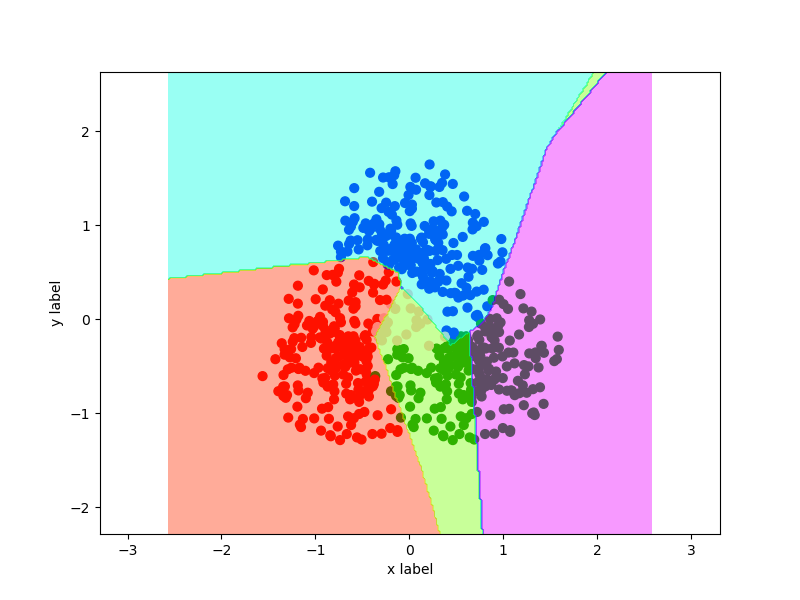

In [92]:
fig, ax = plt.subplots(figsize=(8,6)) 
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
Y = COLOR_LABELS[T]

x_grid, y_grid, predictions = prediction_grid_2d(x_min, x_max, y_min, y_max, prediction)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()

In [81]:
X.shape

(710, 2)